In [2]:
!pip install factor_analyzer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV
import shap
from factor_analyzer import FactorAnalyzer
import warnings
warnings.filterwarnings('ignore')
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Set style for plots
#plt.style.use('seaborn')
sns.set_theme(style="darkgrid")
sns.set_palette("husl")

In [5]:
# %%

# Load and explore the data
df = pd.read_csv('/content/africa_stock_5yrs.csv')
print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

Data shape: (16320, 7)

First few rows:
         date         open         high          low        close  \
0  2019-01-02     0.074821     0.074821     0.074821     0.074821   
1  2019-01-02  1258.914428  1281.118359  1242.313359  1261.404589   
2  2019-01-02     0.225049     0.225049     0.217221     0.217710   
3  2019-01-02     0.605863     0.605863     0.605863     0.605863   
4  2019-01-02  1220.870311  1233.597798  1199.358092  1214.852423   

        volume        Name  
0  18026840.08  ZENITHBANK  
1    702532.00         ANG  
2   1778300.00        SCOM  
3    178423.00     DANGCEM  
4   1650877.00         SBK  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16320 entries, 0 to 16319
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    16320 non-null  object 
 1   open    16320 non-null  float64
 2   high    16320 non-null  float64
 3   low     16320 non-null  float64
 4   close   16320 non-null  

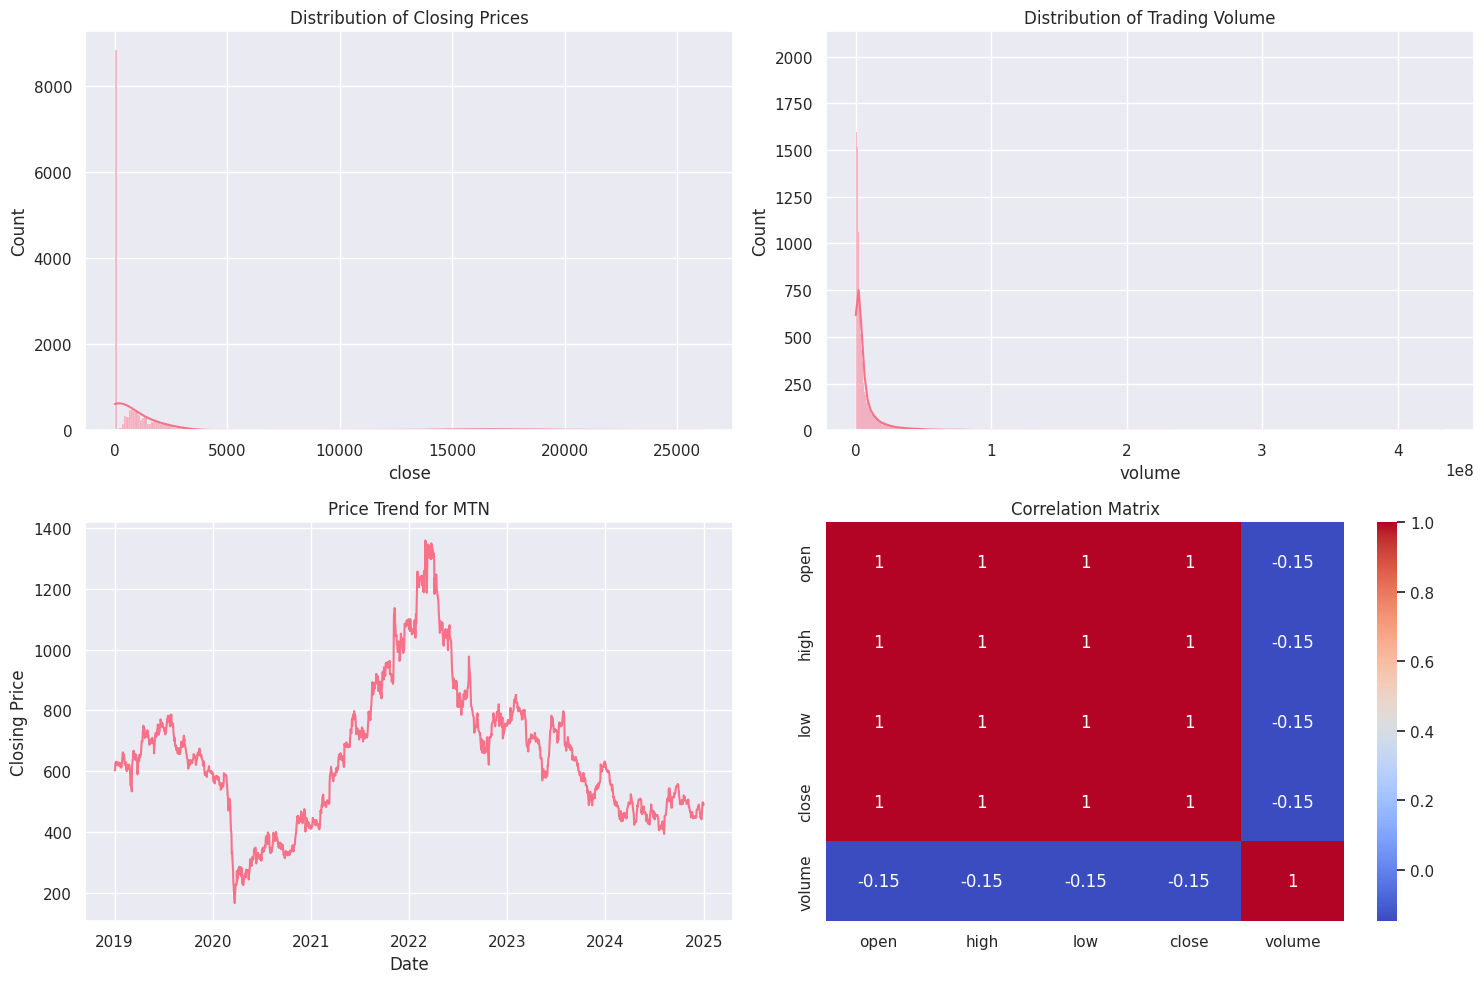

In [6]:
# %%

# EDA and Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of closing prices
plt.subplot(2, 2, 1)
sns.histplot(df['close'], kde=True)
plt.title('Distribution of Closing Prices')

# Plot 2: Volume distribution
plt.subplot(2, 2, 2)
sns.histplot(df['volume'], kde=True)
plt.title('Distribution of Trading Volume')

# Plot 3: Price trends for a sample stock
plt.subplot(2, 2, 3)
sample_stock = df[df['Name'] == 'MTN']
plt.plot(sample_stock['date'], sample_stock['close'])
plt.title('Price Trend for MTN')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Plot 4: Correlation heatmap
plt.subplot(2, 2, 4)
corr_matrix = df[['open', 'high', 'low', 'close', 'volume']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

In [7]:
# %%

print("\nUnique stock names:")
print(df['Name'].unique())
print("Count:", len(df['Name'].unique()))


Unique stock names:
['ZENITHBANK' 'ANG' 'SCOM' 'DANGCEM' 'SBK' 'GTCO' 'SOL' 'MTN' 'NB' 'NPN'
 'MTNN']
Count: 11


In [8]:
# %%

# Feature Engineering
def create_features(df):
    # Technical indicators
    df['daily_return'] = df.groupby('Name')['close'].pct_change()
    df['volatility'] = df.groupby('Name')['daily_return'].rolling(window=20).std().reset_index(0, drop=True)
    df['moving_avg_20'] = df.groupby('Name')['close'].rolling(window=20).mean().reset_index(0, drop=True)
    df['moving_avg_50'] = df.groupby('Name')['close'].rolling(window=50).mean().reset_index(0, drop=True)

    # Price momentum
    df['momentum'] = df.groupby('Name')['close'].pct_change(periods=5)

    # Volume features
    df['volume_ma'] = df.groupby('Name')['volume'].rolling(window=20).mean().reset_index(0, drop=True)
    df['volume_std'] = df.groupby('Name')['volume'].rolling(window=20).std().reset_index(0, drop=True)

    # Price range features
    df['price_range'] = (df['high'] - df['low']) / df['low']
    df['price_range_ma'] = df.groupby('Name')['price_range'].rolling(window=20).mean().reset_index(0, drop=True)

    return df

df = create_features(df)
df = df.dropna()

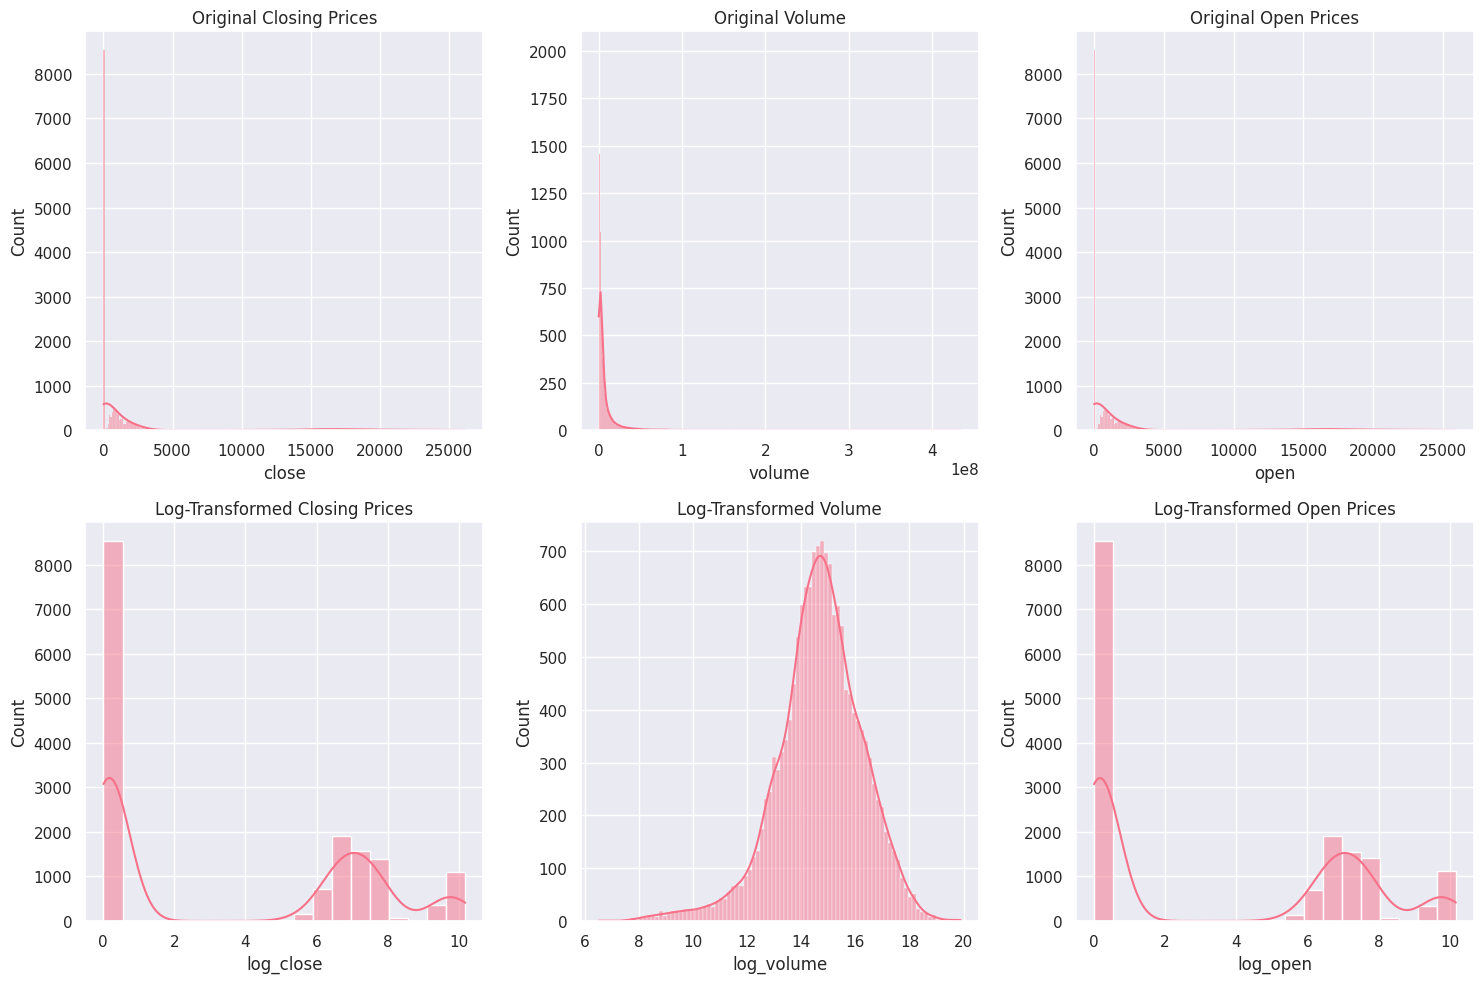

In [9]:
# %%

# Log Transformations of Various Features
df['log_close'] = np.log1p(df['close'])
df['log_volume'] = np.log1p(df['volume'])
df['log_open'] = np.log1p(df['open'])
df['log_high'] = np.log1p(df['high'])
df['log_low'] = np.log1p(df['low'])

# Plot the distributions before and after transformations
plt.figure(figsize=(15, 10))

# Closing Prices
plt.subplot(2, 3, 1)
sns.histplot(df['close'], kde=True)
plt.title('Original Closing Prices')

plt.subplot(2, 3, 4)
sns.histplot(df['log_close'], kde=True)
plt.title('Log-Transformed Closing Prices')

# Volume
plt.subplot(2, 3, 2)
sns.histplot(df['volume'], kde=True)
plt.title('Original Volume')

plt.subplot(2, 3, 5)
sns.histplot(df['log_volume'], kde=True)
plt.title('Log-Transformed Volume')

# Open Prices
plt.subplot(2, 3, 3)
sns.histplot(df['open'], kde=True)
plt.title('Original Open Prices')

plt.subplot(2, 3, 6)
sns.histplot(df['log_open'], kde=True)
plt.title('Log-Transformed Open Prices')

plt.tight_layout()
plt.show()

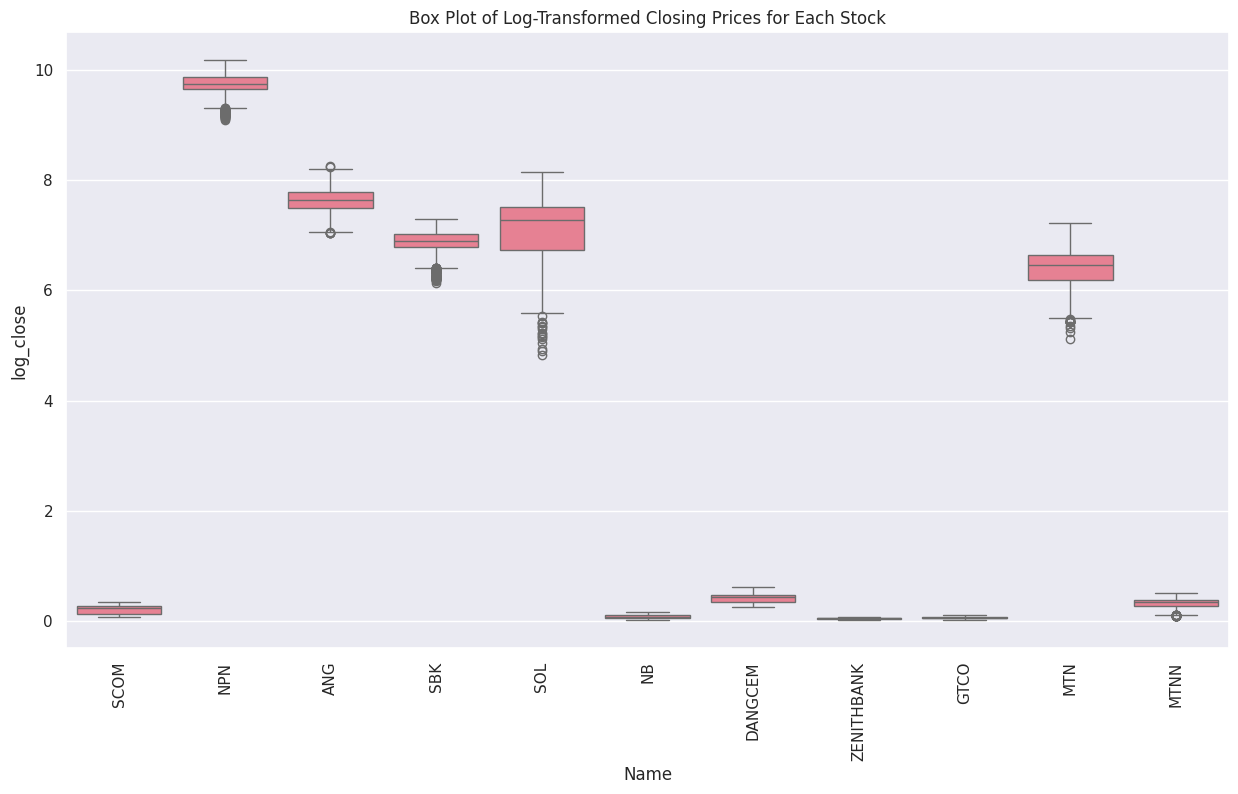

In [10]:
# %%

# Box Plot for Log-Transformed Closing Prices
plt.figure(figsize=(15, 8))
sns.boxplot(x='Name', y='log_close', data=df)
plt.xticks(rotation=90)
plt.title('Box Plot of Log-Transformed Closing Prices for Each Stock')
plt.show()

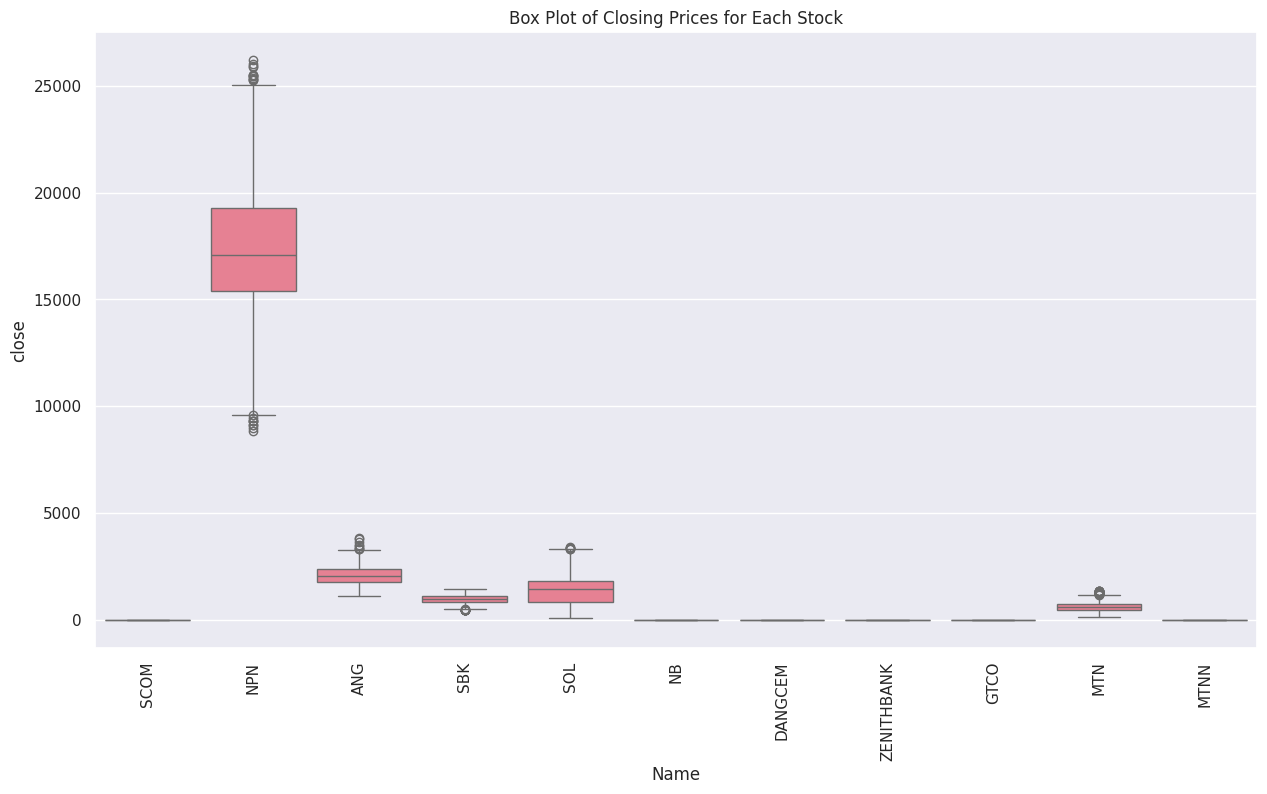

In [11]:
# %%

# Box Plot for Closing Prices of Each Stock
plt.figure(figsize=(15, 8))
sns.boxplot(x='Name', y='close', data=df)
plt.xticks(rotation=90)
plt.title('Box Plot of Closing Prices for Each Stock')
plt.show()

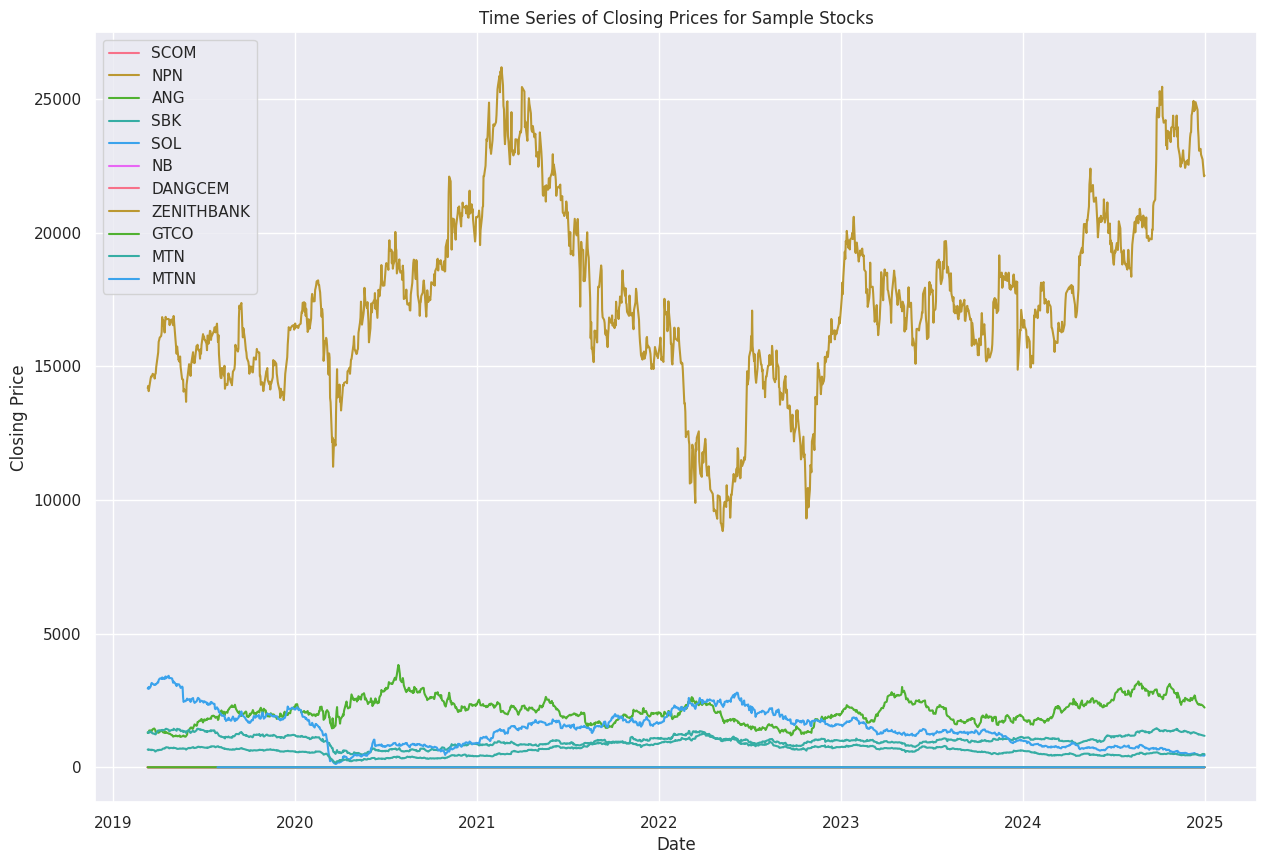

In [12]:
# %%

# Time Series Plot for a Sample Stock
sample_stocks = df['Name'].unique()[:]
plt.figure(figsize=(15, 10))
for stock in sample_stocks:
    stock_data = df[df['Name'] == stock]
    plt.plot(stock_data['date'], stock_data['close'], label=stock)
plt.title('Time Series of Closing Prices for Sample Stocks')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

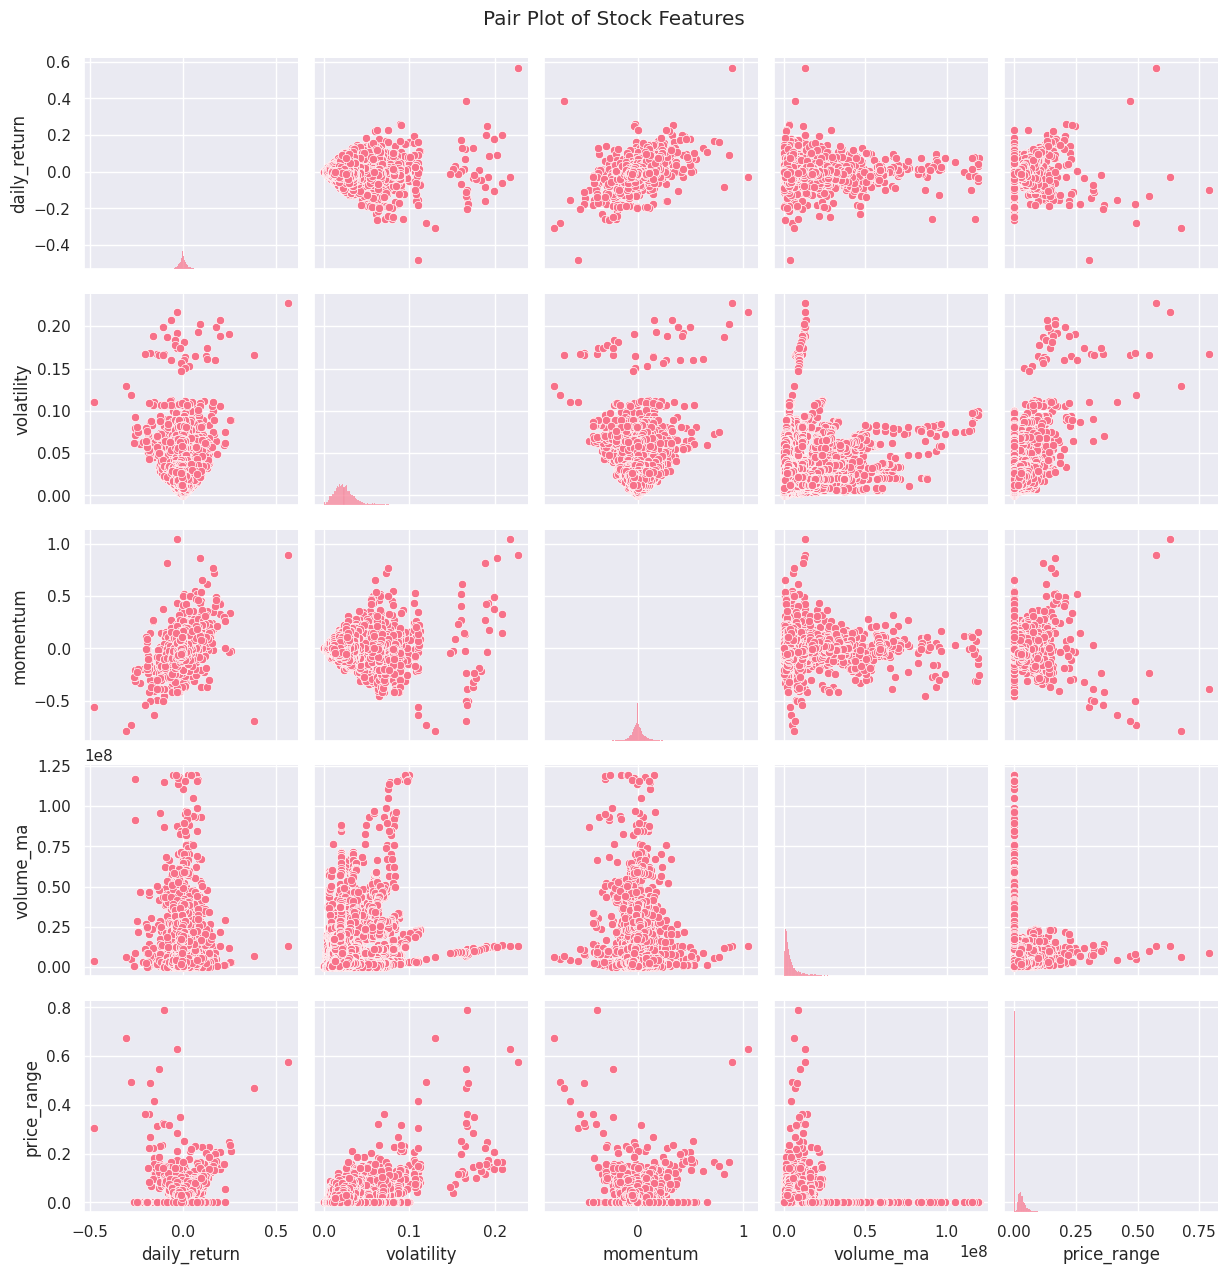

In [13]:
# %%

# Pair Plot for Feature Relationships
sns.pairplot(df[['daily_return', 'volatility', 'momentum', 'volume_ma', 'price_range']])
plt.suptitle('Pair Plot of Stock Features', y=1.02)
plt.show()

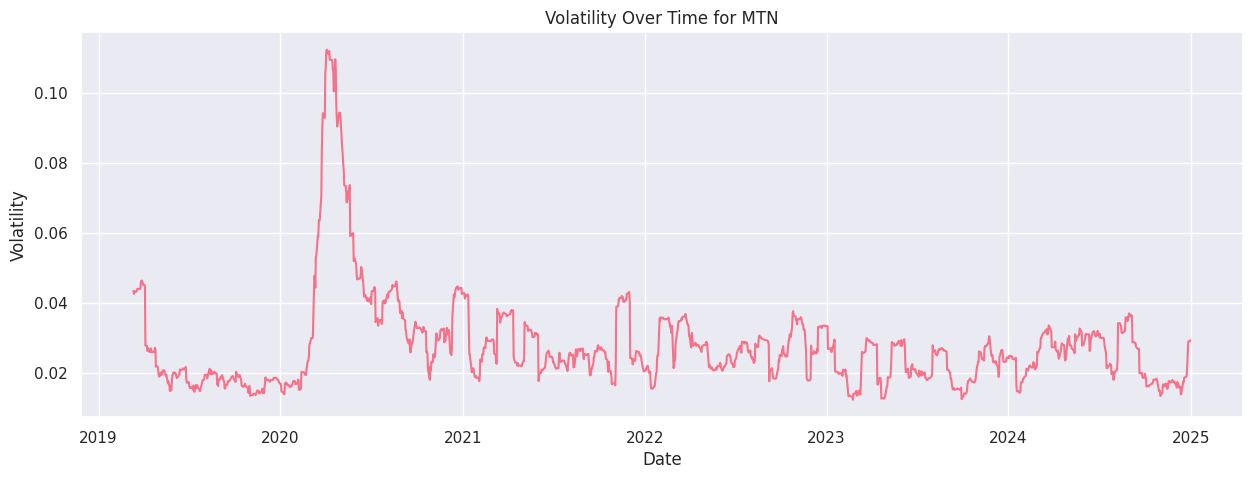

In [14]:
# %%

# Volatility Over Time for a Sample Stock
plt.figure(figsize=(15, 5))
sample_stock_data = df[df['Name'] == 'MTN']
plt.plot(sample_stock_data['date'], sample_stock_data['volatility'])
plt.title('Volatility Over Time for MTN')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

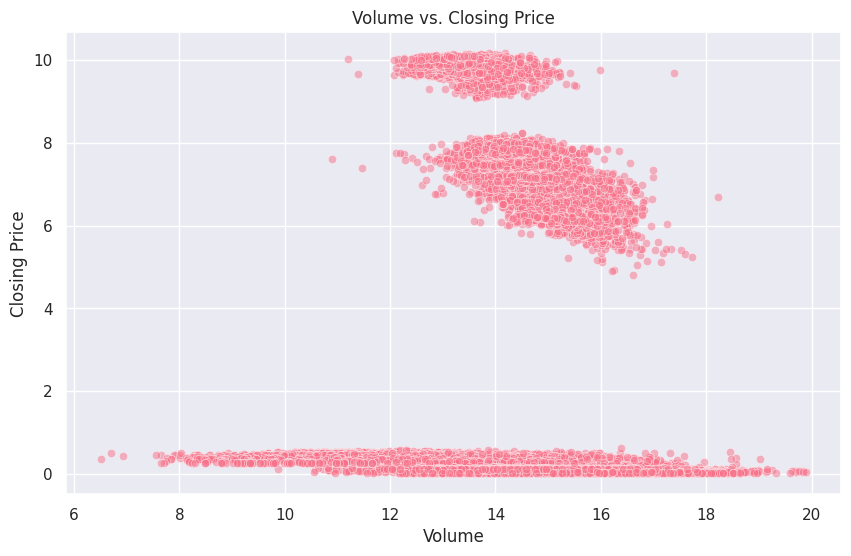

In [15]:
# %%

# Volume vs. Closing Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_volume', y='log_close', data=df, alpha=0.5)
plt.title('Volume vs. Closing Price')
plt.xlabel('Volume')
plt.ylabel('Closing Price')
plt.show()

In [16]:
# %%

df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name',
       'daily_return', 'volatility', 'moving_avg_20', 'moving_avg_50',
       'momentum', 'volume_ma', 'volume_std', 'price_range', 'price_range_ma',
       'log_close', 'log_volume', 'log_open', 'log_high', 'log_low'],
      dtype='object')

In [17]:
# %%

# Feature Selection for Factor Analysis
features_for_fa = [
    'log_close',        # Price level
    'log_volume',       # Trading activity
    'daily_return',     # Price movement
    'volatility',       # Risk measure
    'momentum',         # Trend strength
    'price_range',      # Daily price range
    'volume_ma',        # Volume trend
    'moving_avg_20'     # Price trend
]

# Perform Factor Analysis
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(df[features_for_fa].dropna())

# Get factor loadings
loadings = pd.DataFrame(fa.loadings_, columns=['Factor1', 'Factor2'], index=features_for_fa)
print("Factor Loadings:")
print(loadings)

Factor Loadings:
                Factor1   Factor2
log_close      0.904257 -0.318786
log_volume     0.053697  0.729613
daily_return   0.016740  0.000396
volatility     0.346776  0.245580
momentum       0.028811 -0.005994
price_range    0.642700  0.072003
volume_ma     -0.179989  0.748184
moving_avg_20  0.444060 -0.316243


In [18]:
# %%

# Calculate Variance Explained
variance = fa.get_factor_variance()
print("\nVariance Explained:")
print(f"Factor 1: {variance[0][0]:.2%}")
print(f"Factor 2: {variance[0][1]:.2%}")
print(f"Total: {sum(variance[0]):.2%}")


Variance Explained:
Factor 1: 158.46%
Factor 2: 135.93%
Total: 294.39%


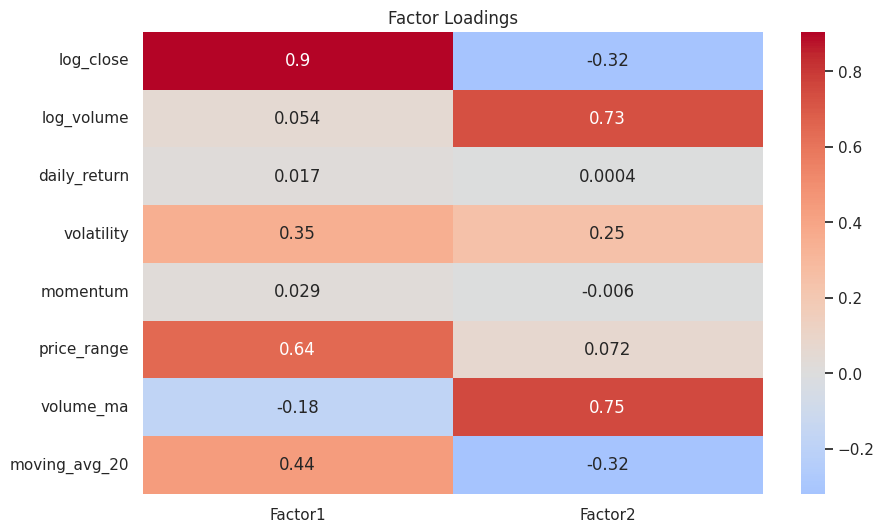

In [19]:
# %%

# Plot Factor Loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Factor Loadings')
plt.show()

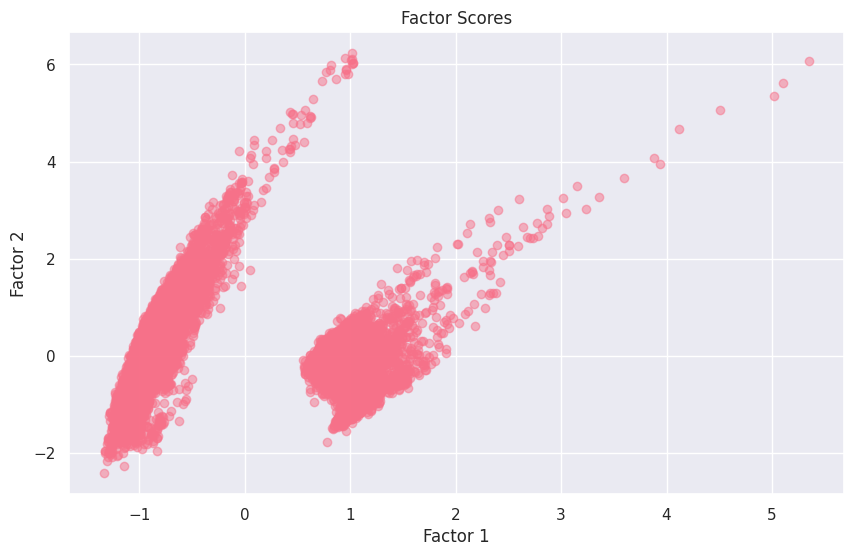

In [20]:
# %%

# Plot Factor Scores
factor_scores = fa.transform(df[features_for_fa].dropna())
plt.figure(figsize=(10, 6))
plt.scatter(factor_scores[:, 0], factor_scores[:, 1], alpha=0.5)
plt.title('Factor Scores')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.show()

In [21]:
# %%

# Factor Analysis Interpretation
print("\nFactor Interpretation:")

# Get absolute loadings for better interpretation
abs_loadings = loadings.abs()

# Identify top features for each factor
factor1_top_features = abs_loadings['Factor1'].nlargest(3).index
factor2_top_features = abs_loadings['Factor2'].nlargest(3).index

print("\nFactor 1 (Market Risk/Price Movement) is most influenced by:")
for feature in factor1_top_features:
    loading = loadings.loc[feature, 'Factor1']
    print(f"- {feature}: {loading:.3f}")

print("\nFactor 2 (Trading Activity) is most influenced by:")
for feature in factor2_top_features:
    loading = loadings.loc[feature, 'Factor2']
    print(f"- {feature}: {loading:.3f}")


Factor Interpretation:

Factor 1 (Market Risk/Price Movement) is most influenced by:
- log_close: 0.904
- price_range: 0.643
- moving_avg_20: 0.444

Factor 2 (Trading Activity) is most influenced by:
- volume_ma: 0.748
- log_volume: 0.730
- log_close: -0.319


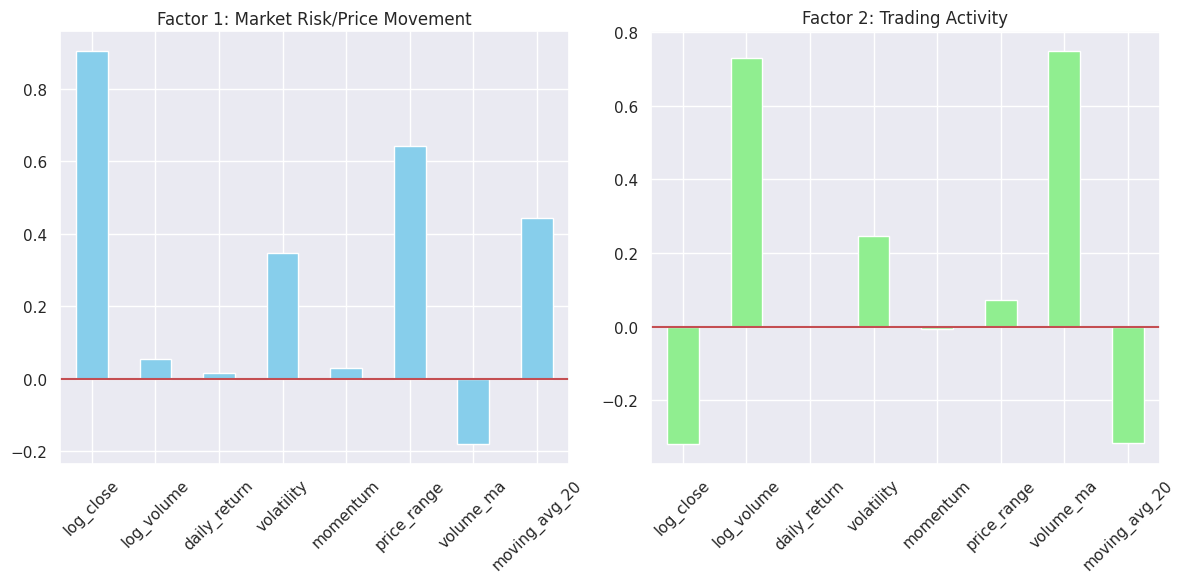

In [22]:
# %%

# Visualize Factor Contributions
plt.figure(figsize=(12, 6))

# Factor 1 Contributions
plt.subplot(1, 2, 1)
loadings['Factor1'].plot(kind='bar', color='skyblue')
plt.title('Factor 1: Market Risk/Price Movement')
plt.axhline(y=0, color='r', linestyle='-')
plt.xticks(rotation=45)
plt.tight_layout()

# Factor 2 Contributions
plt.subplot(1, 2, 2)
loadings['Factor2'].plot(kind='bar', color='lightgreen')
plt.title('Factor 2: Trading Activity')
plt.axhline(y=0, color='r', linestyle='-')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

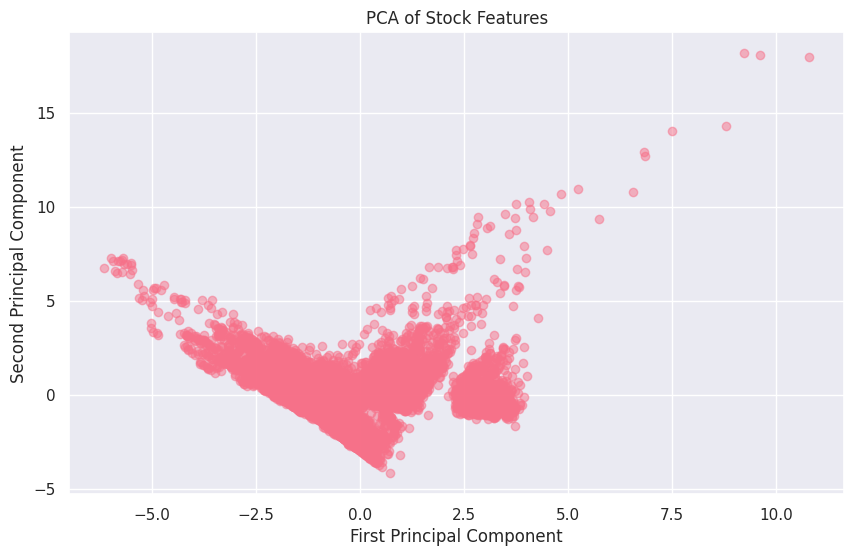

In [23]:
# %%

# PCA Analysis
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features_for_fa])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA of Stock Features')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [24]:
# %%

# Feature Selection for Anomaly Detection
features_to_keep = [
    'log_close',        # Transformed closing price
    'log_volume',       # Transformed volume
    'daily_return',     # Price movement
    'volatility',       # Price stability
    'momentum',         # Price trend
    'volume_ma',        # Volume trend
    'price_range',      # Daily price range
    'moving_avg_20'     # Short-term trend
]

# Select only the features we want to keep
X = df[features_to_keep].dropna().values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
# %%

# 1. K-Means hyperparameter tuning
silhouette_scores = []
k_range = range(2, 15)  # Test more cluster options

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K={k}, Silhouette Score: {silhouette_avg:.4f}")

# Find optimal number of clusters
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Train K-Means with optimal parameters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Calculate distances to cluster centers for anomaly detection
distances = kmeans.transform(X_scaled)
min_distances = np.min(distances, axis=1)

# Set threshold using percentile method
threshold_percentile = 95  # Top 5% as anomalies
threshold = np.percentile(min_distances, threshold_percentile)
kmeans_anomalies = min_distances > threshold

print(f"K-Means detected {np.sum(kmeans_anomalies)} anomalies ({np.mean(kmeans_anomalies):.2%})")

K=2, Silhouette Score: 0.2576
K=3, Silhouette Score: 0.2452
K=4, Silhouette Score: 0.3019
K=5, Silhouette Score: 0.3106
K=6, Silhouette Score: 0.3039
K=7, Silhouette Score: 0.2998
K=8, Silhouette Score: 0.3100
K=9, Silhouette Score: 0.2980
K=10, Silhouette Score: 0.3006
K=11, Silhouette Score: 0.2735
K=12, Silhouette Score: 0.2398
K=13, Silhouette Score: 0.2565
K=14, Silhouette Score: 0.2202
Optimal number of clusters: 5
K-Means detected 789 anomalies (5.00%)


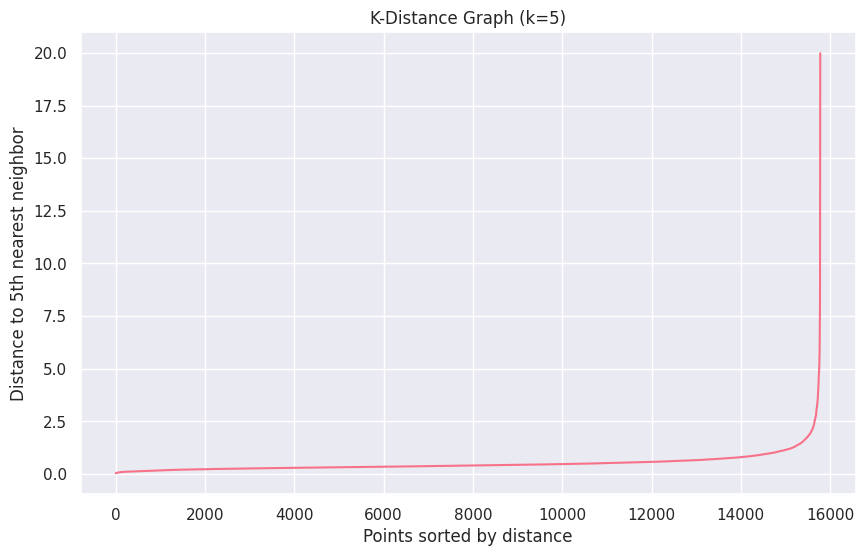

eps=0.5, min_samples=5, silhouette=-0.1347, noise_ratio=0.2491
eps=0.5, min_samples=10, silhouette=0.3050, noise_ratio=0.3248
eps=0.5, min_samples=15, silhouette=0.2797, noise_ratio=0.3765
eps=0.5, min_samples=20, silhouette=0.3923, noise_ratio=0.4142
eps=0.7, min_samples=5, silhouette=0.1617, noise_ratio=0.1126
eps=0.7, min_samples=10, silhouette=0.3145, noise_ratio=0.1485
eps=0.7, min_samples=15, silhouette=0.3512, noise_ratio=0.1761
eps=0.7, min_samples=20, silhouette=0.3564, noise_ratio=0.1940
eps=1.0, min_samples=5, silhouette=0.2782, noise_ratio=0.0485
eps=1.0, min_samples=15, silhouette=0.3126, noise_ratio=0.0730
eps=1.0, min_samples=20, silhouette=0.3167, noise_ratio=0.0812
eps=1.5, min_samples=5, silhouette=0.5362, noise_ratio=0.0178
Optimal DBSCAN parameters: eps=1.5, min_samples=5
Expected anomaly ratio: 0.0178
DBSCAN detected 281 anomalies (1.78%)


In [26]:
# %%

# 2. DBSCAN hyperparameter tuning
from sklearn.neighbors import NearestNeighbors

k = 5  # Number of neighbors to consider
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.title(f'K-Distance Graph (k={k})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.grid(True)
plt.show()

# Based on the elbow in the k-distance graph, select candidate eps values
eps_candidates = [0.3, 0.5, 0.7, 1.0, 1.5]
min_samples_candidates = [5, 10, 15, 20]

# Grid search for DBSCAN parameters
best_silhouette = -1
best_eps = None
best_min_samples = None
best_noise_ratio = 0

results = []

for eps in eps_candidates:
    for min_samples in min_samples_candidates:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        # Skip configurations where all points are noise (-1)
        if len(np.unique(labels)) <= 1:
            continue

        # Calculate noise ratio
        noise_ratio = np.mean(labels == -1)

        # Skip if too many or too few noise points
        if noise_ratio > 0.5 or noise_ratio < 0.01:
            continue

        # Calculate silhouette score for non-noise points
        non_noise_mask = labels != -1
        if np.sum(non_noise_mask) > 1:
            try:
                score = silhouette_score(X_scaled[non_noise_mask], labels[non_noise_mask])
                results.append((eps, min_samples, score, noise_ratio))
                print(f"eps={eps}, min_samples={min_samples}, silhouette={score:.4f}, noise_ratio={noise_ratio:.4f}")

                if score > best_silhouette:
                    best_silhouette = score
                    best_eps = eps
                    best_min_samples = min_samples
                    best_noise_ratio = noise_ratio
            except:
                continue

# Train DBSCAN with optimal parameters
if best_eps is not None:
    print(f"Optimal DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}")
    print(f"Expected anomaly ratio: {best_noise_ratio:.4f}")

    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    dbscan_anomalies = dbscan_labels == -1
else:
    print("Could not find optimal DBSCAN parameters. Using defaults.")
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    dbscan_anomalies = dbscan_labels == -1

print(f"DBSCAN detected {np.sum(dbscan_anomalies)} anomalies ({np.mean(dbscan_anomalies):.2%})")

In [27]:
# %%

# 3. Isolation Forest hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Parameter space for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_samples': ['auto'] + list(randint(100, len(X_scaled)).rvs(5)),
    'contamination': uniform(0.01, 0.15),
    'max_features': randint(1, X_scaled.shape[1] + 1),
    'bootstrap': [True, False]
}

# Isolation Forest baseline model
base_iso_forest = IsolationForest(random_state=42)

# Define a custom scorer for unsupervised anomaly detection
def custom_scorer(estimator, X):
    # Higher is better, but decision_function returns negative values for anomalies
    # So we take the mean negative decision function
    return -np.mean(estimator.decision_function(X))

n_iter = 20  # Number of parameter settings sampled
search = RandomizedSearchCV(
    base_iso_forest,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=5,
    scoring=custom_scorer,
    random_state=42,
    n_jobs=-1
)

# Reduce dataset size for faster tuning if needed
X_subset = X_scaled
if len(X_scaled) > 5000:
    X_subset = X_scaled[np.random.choice(len(X_scaled), 5000, replace=False)]

search.fit(X_subset)

print(f"Best Isolation Forest parameters: {search.best_params_}")

# Train Isolation Forest with optimal parameters
iso_forest = IsolationForest(**search.best_params_, random_state=42)
iso_forest.fit(X_scaled)

# Get anomaly predictions
iso_labels = iso_forest.predict(X_scaled)
iso_anomalies = iso_labels == -1

# Get anomaly scores for visualization
iso_scores = -iso_forest.decision_function(X_scaled)  # Negative for better visualization

print(f"Isolation Forest detected {np.sum(iso_anomalies)} anomalies ({np.mean(iso_anomalies):.2%})")

Best Isolation Forest parameters: {'bootstrap': False, 'contamination': np.float64(0.15078290635236252), 'max_features': 2, 'max_samples': np.int64(8109), 'n_estimators': 326}
Isolation Forest detected 2380 anomalies (15.08%)


In [28]:
# %%

# 4. One-Class SVM hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Parameter grid for GridSearchCV
param_grid = {
    'nu': [0.01, 0.05, 0.1, 0.15, 0.2],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1.0]
}

# Define base model
base_oc_svm = OneClassSVM()

# GridSearchCV for hyperparameter optimization (on subset for speed)
X_subset = X_scaled
if len(X_scaled) > 2000:
    X_subset = X_scaled[np.random.choice(len(X_scaled), 2000, replace=False)]

# Simple cross-validation for unsupervised learning
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Find best parameters manually since GridSearchCV doesn't work directly with OneClassSVM
best_score = float('inf')
best_params = {'nu': 0.1, 'kernel': 'rbf', 'gamma': 'scale'}

for nu in param_grid['nu']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
            params = {'nu': nu, 'kernel': kernel, 'gamma': gamma}
            cv_scores = []

            for train_idx, val_idx in cv.split(X_subset):
                model = OneClassSVM(**params)
                model.fit(X_subset[train_idx])

                # Use decision_function as score
                val_scores = -model.decision_function(X_subset[val_idx])
                cv_scores.append(np.mean(val_scores))

            mean_score = np.mean(cv_scores)
            print(f"nu={nu}, kernel={kernel}, gamma={gamma}, score={mean_score:.6f}")

            if mean_score < best_score:
                best_score = mean_score
                best_params = params

print(f"Best One-Class SVM parameters: {best_params}")

# Train One-Class SVM with optimal parameters
oc_svm = OneClassSVM(**best_params)
oc_svm.fit(X_scaled)

# Get anomaly predictions
svm_labels = oc_svm.predict(X_scaled)
svm_anomalies = svm_labels == -1

# Get anomaly scores
svm_scores = -oc_svm.decision_function(X_scaled)

print(f"One-Class SVM detected {np.sum(svm_anomalies)} anomalies ({np.mean(svm_anomalies):.2%})")

nu=0.01, kernel=rbf, gamma=scale, score=-0.102242
nu=0.01, kernel=rbf, gamma=auto, score=-0.111448
nu=0.01, kernel=rbf, gamma=0.1, score=-0.140023
nu=0.01, kernel=rbf, gamma=1.0, score=-0.001159
nu=0.01, kernel=linear, gamma=scale, score=-0.000006
nu=0.01, kernel=linear, gamma=auto, score=-0.000006
nu=0.01, kernel=linear, gamma=0.1, score=-0.000006
nu=0.01, kernel=linear, gamma=1.0, score=-0.000006
nu=0.01, kernel=poly, gamma=scale, score=-0.022381
nu=0.01, kernel=poly, gamma=auto, score=-0.017092
nu=0.01, kernel=poly, gamma=0.1, score=-0.008851
nu=0.01, kernel=poly, gamma=1.0, score=-8.720946
nu=0.05, kernel=rbf, gamma=scale, score=-0.712996
nu=0.05, kernel=rbf, gamma=auto, score=-0.820970
nu=0.05, kernel=rbf, gamma=0.1, score=-1.184323
nu=0.05, kernel=rbf, gamma=1.0, score=-0.005931
nu=0.05, kernel=linear, gamma=scale, score=0.000051
nu=0.05, kernel=linear, gamma=auto, score=0.000051
nu=0.05, kernel=linear, gamma=0.1, score=0.000051
nu=0.05, kernel=linear, gamma=1.0, score=0.000051
n

n_components=2, covariance_type=full, BIC=240650.92
n_components=2, covariance_type=tied, BIC=288142.01
n_components=2, covariance_type=diag, BIC=293454.38
n_components=2, covariance_type=spherical, BIC=322065.30
n_components=3, covariance_type=full, BIC=9582.04
n_components=3, covariance_type=tied, BIC=265765.29
n_components=3, covariance_type=diag, BIC=57776.24
n_components=3, covariance_type=spherical, BIC=315408.29
n_components=4, covariance_type=full, BIC=-33252.66
n_components=4, covariance_type=tied, BIC=227229.71
n_components=4, covariance_type=diag, BIC=13867.68
n_components=4, covariance_type=spherical, BIC=300431.27
n_components=5, covariance_type=full, BIC=-52749.35
n_components=5, covariance_type=tied, BIC=219446.08
n_components=5, covariance_type=diag, BIC=-9146.73
n_components=5, covariance_type=spherical, BIC=260380.55
n_components=6, covariance_type=full, BIC=-64958.58
n_components=6, covariance_type=tied, BIC=214788.78
n_components=6, covariance_type=diag, BIC=-24902.

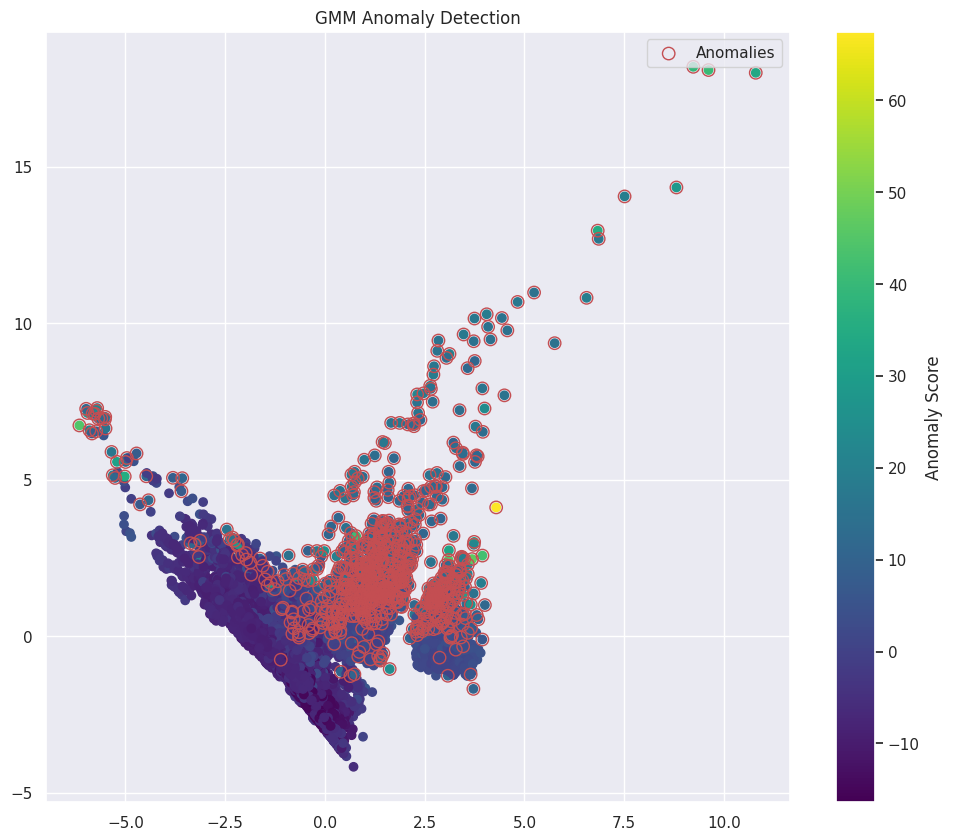

In [29]:
# %%

# GMM hyperparameter tuning
n_components_range = range(2, 10)
covariance_types = ['full', 'tied', 'diag', 'spherical']

best_bic = np.inf
best_n_components = 3
best_covariance_type = 'full'

bic_results = []

for n_components in n_components_range:
    for covariance_type in covariance_types:
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            random_state=42
        )
        gmm.fit(X_scaled)
        bic = gmm.bic(X_scaled)
        bic_results.append((n_components, covariance_type, bic))
        print(f"n_components={n_components}, covariance_type={covariance_type}, BIC={bic:.2f}")

        if bic < best_bic:
            best_bic = bic
            best_n_components = n_components
            best_covariance_type = covariance_type

print(f"Optimal GMM parameters: n_components={best_n_components}, covariance_type={best_covariance_type}")

# Train GMM with optimal parameters
gmm = GaussianMixture(
    n_components=best_n_components,
    covariance_type=best_covariance_type,
    random_state=42
)
gmm.fit(X_scaled)

# Calculate anomaly scores (negative log-likelihood)
gmm_scores = -gmm.score_samples(X_scaled)

# Set threshold for anomaly detection using percentile
anomaly_threshold_percentile = 95  # Top 5% as anomalies
gmm_threshold = np.percentile(gmm_scores, anomaly_threshold_percentile)
gmm_anomalies = gmm_scores > gmm_threshold

print(f"GMM detected {np.sum(gmm_anomalies)} anomalies ({np.mean(gmm_anomalies):.2%})")

# Plot GMM density and anomalies
if X_scaled.shape[1] > 1:  # If more than 1 dimension, use PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(12, 10))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_scores, cmap='viridis')
    plt.colorbar(label='Anomaly Score')
    plt.scatter(X_pca[gmm_anomalies, 0], X_pca[gmm_anomalies, 1],
                edgecolors='r', facecolors='none', s=80, label='Anomalies')
    plt.title('GMM Anomaly Detection')
    plt.legend()
    plt.show()

In [34]:
# %%

# 5. Autoencoder hyperparameter tuning
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Split data for validation
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Try different architectures and hyperparameters
architectures = [
    # (encoding_dim, hidden_layers, dropout_rate, activation)
    (2, [], 0.0, 'relu'),
    (4, [8], 0.2, 'relu'),
    (8, [16, 8], 0.3, 'relu'),
    (4, [8], 0.2, 'tanh')
]

learning_rates = [0.01, 0.001, 0.0001]
best_val_loss = float('inf')
best_autoencoder = None
best_config = None

for lr in learning_rates:
    for config in architectures:
        encoding_dim, hidden_layers, dropout_rate, activation = config

        # Build the encoder
        input_dim = X_scaled.shape[1]
        inputs = Input(shape=(input_dim,))

        # Encoder part
        encoded = inputs
        for units in hidden_layers:
            encoded = Dense(units, activation=activation)(encoded)
            if dropout_rate > 0:
                encoded = Dropout(dropout_rate)(encoded)

        # Bottleneck layer
        encoded = Dense(encoding_dim, activation=activation)(encoded)

        # Decoder part
        decoded = encoded
        for units in reversed(hidden_layers):
            decoded = Dense(units, activation=activation)(decoded)
            if dropout_rate > 0:
                decoded = Dropout(dropout_rate)(decoded)

        # Output layer
        decoded = Dense(input_dim, activation='sigmoid')(decoded)

        # Build autoencoder model
        autoencoder = Model(inputs, decoded)
        autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mse')

        # Early stopping and learning rate reduction
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        # Train the model
        history = autoencoder.fit(
            X_train, X_train,
            epochs=100,
            batch_size=32,
            shuffle=True,
            validation_data=(X_val, X_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        val_loss = min(history.history['val_loss'])
        print(f"Config: {config}, LR: {lr}, Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_autoencoder = autoencoder
            best_config = (config, lr)

print(f"Best autoencoder config: {best_config}, validation loss: {best_val_loss:.6f}")



Config: (2, [], 0.0, 'relu'), LR: 0.01, Val Loss: 0.741169
Config: (4, [8], 0.2, 'relu'), LR: 0.01, Val Loss: 0.708674
Config: (8, [16, 8], 0.3, 'relu'), LR: 0.01, Val Loss: 0.847607
Config: (4, [8], 0.2, 'tanh'), LR: 0.01, Val Loss: 0.682947
Config: (2, [], 0.0, 'relu'), LR: 0.001, Val Loss: 0.746211
Config: (4, [8], 0.2, 'relu'), LR: 0.001, Val Loss: 0.723157
Config: (8, [16, 8], 0.3, 'relu'), LR: 0.001, Val Loss: 0.753006
Config: (4, [8], 0.2, 'tanh'), LR: 0.001, Val Loss: 0.675658
Config: (2, [], 0.0, 'relu'), LR: 0.0001, Val Loss: 0.805889
Config: (4, [8], 0.2, 'relu'), LR: 0.0001, Val Loss: 0.735564
Config: (8, [16, 8], 0.3, 'relu'), LR: 0.0001, Val Loss: 0.769535
Config: (4, [8], 0.2, 'tanh'), LR: 0.0001, Val Loss: 0.741721
Best autoencoder config: ((4, [8], 0.2, 'tanh'), 0.001), validation loss: 0.675658


In [35]:
# Use the best autoencoder for anomaly detection
autoencoder = best_autoencoder

# Get reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# Set threshold for anomaly detection
anomaly_threshold_percentile = 95
mse_threshold = np.percentile(mse, anomaly_threshold_percentile)
autoencoder_anomalies = mse > mse_threshold

print(f"Autoencoder detected {np.sum(autoencoder_anomalies)} anomalies ({np.mean(autoencoder_anomalies):.2%})")



494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder detected 789 anomalies (5.00%)


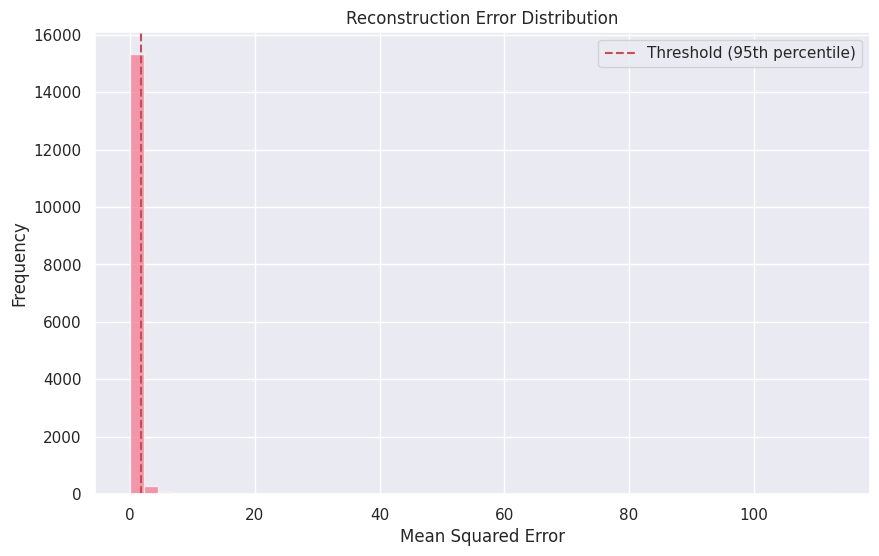

In [36]:
# Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.7)
plt.axvline(mse_threshold, color='r', linestyle='--', label=f'Threshold ({anomaly_threshold_percentile}th percentile)')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [37]:
# Additional visualization for autoencoder
# Visualize the latent space (2D encoding)
if best_config[0][0] == 2:  # If encoding dimension is 2
    # Extract the encoder part
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[len(hidden_layers)+1].output)

    # Get the encoded representations
    encoded_data = encoder.predict(X_scaled)

    # Plot encoded data
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(encoded_data[:, 0], encoded_data[:, 1],
                         c=mse, cmap='viridis', alpha=0.7, s=50)
    plt.colorbar(scatter, label='Reconstruction Error')
    plt.scatter(encoded_data[autoencoder_anomalies, 0], encoded_data[autoencoder_anomalies, 1],
                edgecolors='r', facecolors='none', s=100, linewidth=1.5, label='Anomalies')
    plt.title('2D Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend()
    plt.show()



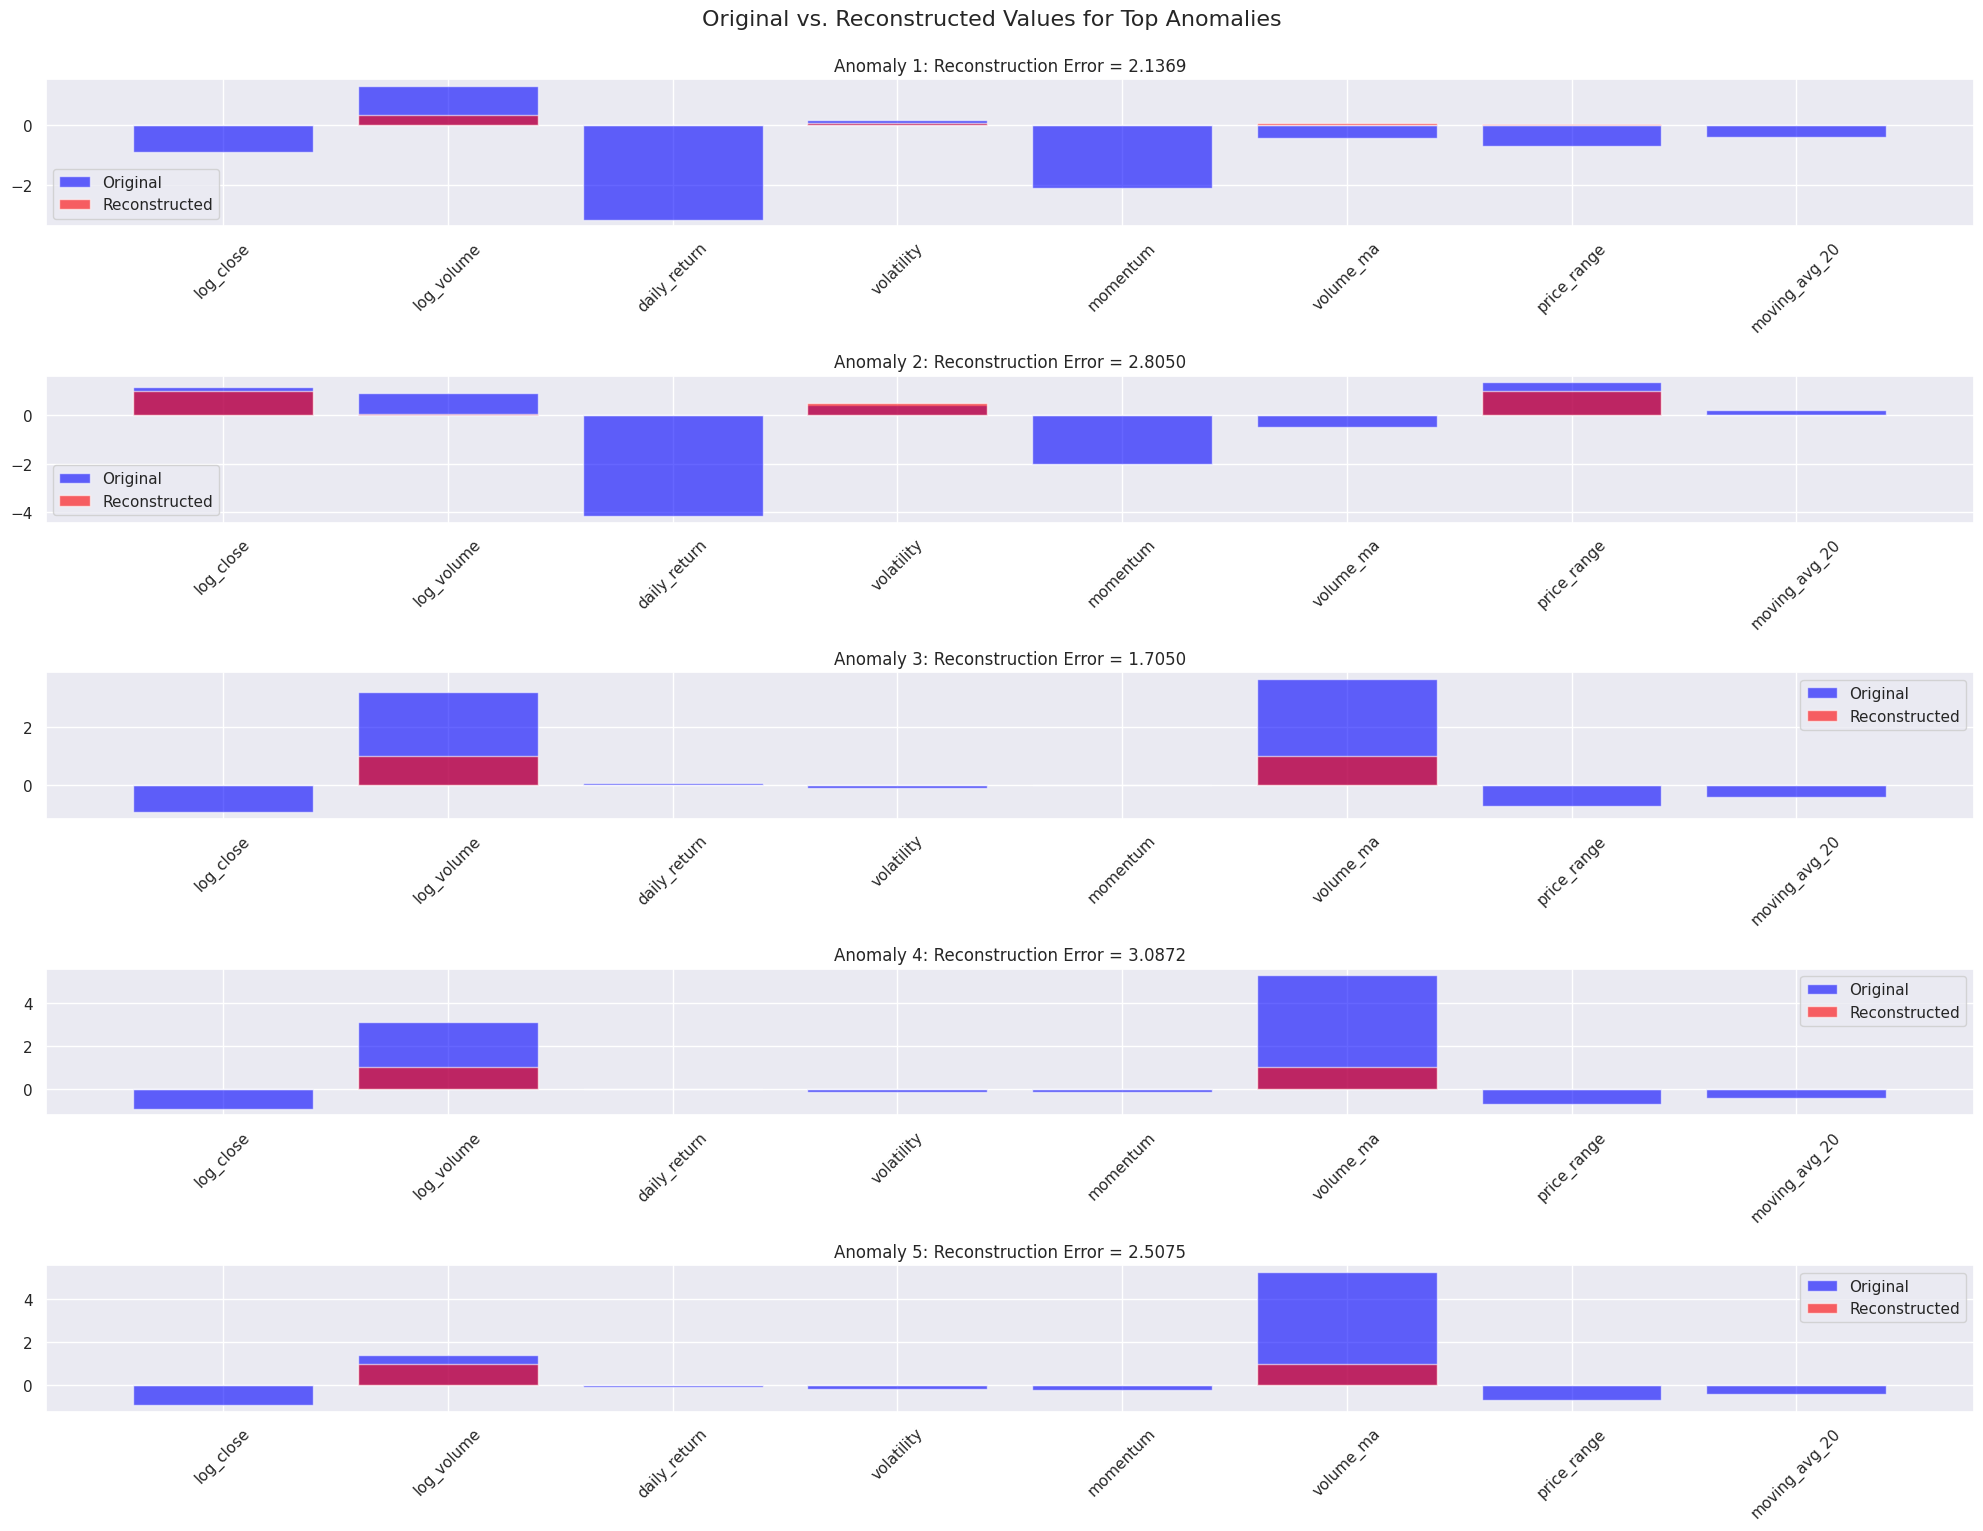

In [38]:
# Compare original and reconstructed values for anomalies
plt.figure(figsize=(20, 15))
n_features = X_scaled.shape[1]
n_anomalies = min(5, np.sum(autoencoder_anomalies))  # Show up to 5 anomalies

# Select a few anomalies to plot
anomaly_indices = np.where(autoencoder_anomalies)[0][:n_anomalies]

for i, idx in enumerate(anomaly_indices):
    # Get original and reconstructed data
    original = X_scaled[idx]
    reconstructed = reconstructions[idx]

    # Plot comparison
    plt.subplot(n_anomalies, 1, i+1)
    plt.bar(range(n_features), original, alpha=0.6, label='Original', color='blue')
    plt.bar(range(n_features), reconstructed, alpha=0.6, label='Reconstructed', color='red')
    plt.title(f'Anomaly {i+1}: Reconstruction Error = {mse[idx]:.4f}')
    plt.xticks(range(n_features), features_to_keep, rotation=45)
    plt.legend()

plt.tight_layout()
plt.suptitle('Original vs. Reconstructed Values for Top Anomalies', fontsize=16, y=1.02)
plt.show()



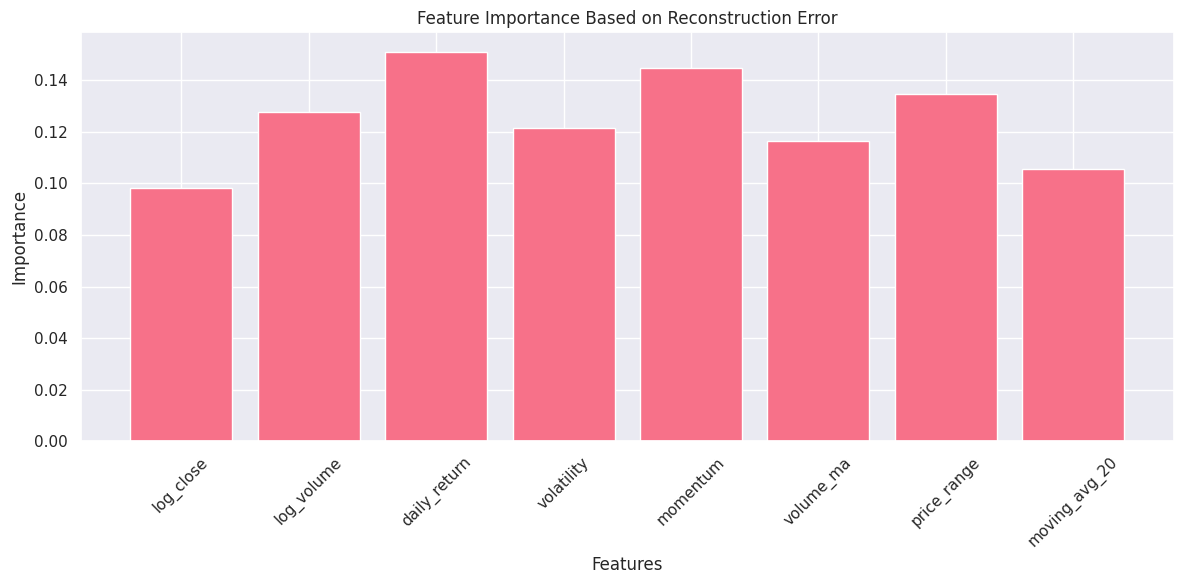

In [39]:
# Feature importance based on reconstruction error
feature_importance = np.zeros(X_scaled.shape[1])

for i in range(X_scaled.shape[1]):
    # Calculate average reconstruction error for each feature
    feature_error = np.mean(np.power(X_scaled[:, i] - reconstructions[:, i], 2))
    feature_importance[i] = feature_error

# Normalize feature importance
feature_importance = feature_importance / np.sum(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), features_to_keep, rotation=45)
plt.title('Feature Importance Based on Reconstruction Error')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [46]:
# %%

# Ensemble of multiple anomaly detection methods
def normalize_scores(scores):
    """Normalize scores to [0,1] range"""
    min_val = np.min(scores)
    max_val = np.max(scores)
    if max_val > min_val:
        return (scores - min_val) / (max_val - min_val)
    else:
        return np.zeros_like(scores)

# Collect scores from all methods
ensemble_scores = np.zeros((X_scaled.shape[0], 5))

# 1. K-Means distances
ensemble_scores[:, 0] = normalize_scores(min_distances)

# 2. Isolation Forest scores
ensemble_scores[:, 1] = normalize_scores(iso_scores)

# 3. One-Class SVM scores
ensemble_scores[:, 2] = normalize_scores(svm_scores)

# 4. GMM negative log-likelihood
ensemble_scores[:, 3] = normalize_scores(gmm_scores)

# 5. Autoencoder reconstruction error
ensemble_scores[:, 4] = normalize_scores(mse)

# Combine scores (weighted average)
weights = [0.15, 0.25, 0.2, 0.2, 0.2]  # Adjust based on individual performance
ensemble_anomaly_scores = np.average(ensemble_scores, axis=1, weights=weights)

# Set threshold for anomaly detection
ensemble_threshold_percentile = 95
ensemble_threshold = np.percentile(ensemble_anomaly_scores, ensemble_threshold_percentile)
ensemble_anomalies = ensemble_anomaly_scores > ensemble_threshold

print(f"Ensemble method detected {np.sum(ensemble_anomalies)} anomalies ({np.mean(ensemble_anomalies):.2%})")

Ensemble method detected 789 anomalies (5.00%)


In [47]:
# %%

# Evaluate ensemble method performance
# Calculate agreement score (how many methods agree on each point)
agreement_counts = np.zeros(X_scaled.shape[0])
all_anomalies = [kmeans_anomalies, iso_anomalies, svm_anomalies,
                 gmm_anomalies,
                 autoencoder_anomalies
                 ]

for anomaly_set in all_anomalies:
    agreement_counts[anomaly_set] += 1

# High agreement on anomalies suggests more confidence
high_confidence_anomalies = (agreement_counts >= 3) & ensemble_anomalies
print(f"High confidence anomalies (3+ methods agree): {np.sum(high_confidence_anomalies)}")

High confidence anomalies (3+ methods agree): 578



Top anomalies detected by ensemble method:
1. Score: 0.7427, Agreement: 4.0/5 methods
   Stock: SOL, Date: 2020-04-07 00:00:00
   log_close: 5.972232987494204
   log_volume: 16.496138242008644
   daily_return: 0.5666645024445809
   volatility: 0.2269153035331678
   momentum: 0.890688622484429
   volume_ma: 13101879.5
   price_range: 0.5759336099585065
   moving_avg_20: 213.08617922269505

2. Score: 0.6874, Agreement: 4.0/5 methods
   Stock: SOL, Date: 2020-04-08 00:00:00
   log_close: 5.9406408112814075
   log_volume: 16.493149729115377
   daily_return: -0.03117781538685227
   volatility: 0.21666185666187895
   momentum: 1.0474738544395623
   volume_ma: 13105000.0
   price_range: 0.6304854368932039
   moving_avg_20: 215.7775146804764

3. Score: 0.6766, Agreement: 4.0/5 methods
   Stock: SOL, Date: 2020-03-13 00:00:00
   log_close: 5.746420085082727
   log_volume: 16.651839748607237
   daily_return: 0.3847887157692589
   volatility: 0.16590376437320645
   momentum: -0.6940320042778385


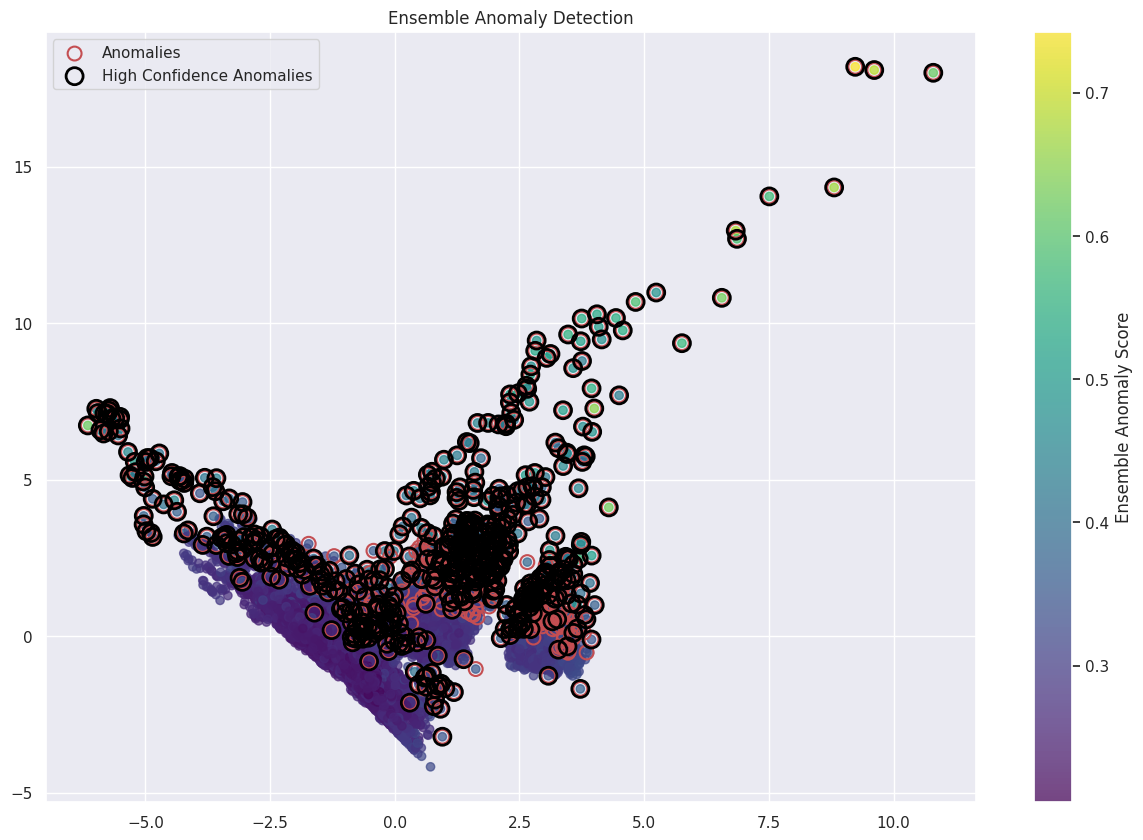

In [48]:
# %%

# Visualize ensemble results
plt.figure(figsize=(15, 10))

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ensemble_anomaly_scores, cmap='viridis', alpha=0.7)
plt.colorbar(label='Ensemble Anomaly Score')
plt.scatter(X_pca[ensemble_anomalies, 0], X_pca[ensemble_anomalies, 1],
            edgecolors='r', facecolors='none', s=100, linewidth=1.5, label='Anomalies')
plt.scatter(X_pca[high_confidence_anomalies, 0], X_pca[high_confidence_anomalies, 1],
            edgecolors='black', facecolors='none', s=150, linewidth=2, label='High Confidence Anomalies')
plt.title('Ensemble Anomaly Detection')
plt.legend()

# Identify most extreme anomalies
top_n = 10
top_anomaly_indices = np.argsort(-ensemble_anomaly_scores)[:top_n]
print("\nTop anomalies detected by ensemble method:")
for i, idx in enumerate(top_anomaly_indices):
    print(f"{i+1}. Score: {ensemble_anomaly_scores[idx]:.4f}, Agreement: {agreement_counts[idx]}/5 methods")

    # Display original data for this point (if available)
    if 'Name' in df.columns:
        stock_name = df['Name'].iloc[idx]
        date = df['date'].iloc[idx] if 'date' in df.columns else "N/A"
        print(f"   Stock: {stock_name}, Date: {date}")

        # Display key metrics for this point
        for feature in features_to_keep:
            if feature in df.columns:
                value = df[feature].iloc[idx]
                print(f"   {feature}: {value}")
        print()

In [49]:
# %%

# Comprehensive evaluation of anomaly detection results
print("\n===== ANOMALY DETECTION EVALUATION =====")

# Compare detection rates between methods
methods = [
    ("K-Means", kmeans_anomalies),
    ("Isolation Forest", iso_anomalies),
    ("One-Class SVM", svm_anomalies),
    ("GMM", gmm_anomalies),
    ("Autoencoder", autoencoder_anomalies),
    ("Ensemble", ensemble_anomalies)
]

print("\nAnomalies detected by each method:")
for name, anomalies in methods:
    print(f"{name}: {np.sum(anomalies)} ({np.mean(anomalies):.2%})")


===== ANOMALY DETECTION EVALUATION =====

Anomalies detected by each method:
K-Means: 789 (5.00%)
Isolation Forest: 2380 (15.08%)
One-Class SVM: 3167 (20.07%)
GMM: 789 (5.00%)
Autoencoder: 789 (5.00%)
Ensemble: 789 (5.00%)


In [50]:
# %%

# Calculate overlap between methods
print("\nOverlap between methods:")
for i, (name1, anomalies1) in enumerate(methods):
    for j, (name2, anomalies2) in enumerate(methods):
        if i < j:
            overlap = np.logical_and(anomalies1, anomalies2)
            jaccard = np.sum(overlap) / np.sum(np.logical_or(anomalies1, anomalies2))
            print(f"{name1} vs {name2}: {np.sum(overlap)} common anomalies, Jaccard={jaccard:.4f}")


Overlap between methods:
K-Means vs Isolation Forest: 735 common anomalies, Jaccard=0.3020
K-Means vs One-Class SVM: 6 common anomalies, Jaccard=0.0015
K-Means vs GMM: 384 common anomalies, Jaccard=0.3216
K-Means vs Autoencoder: 570 common anomalies, Jaccard=0.5655
K-Means vs Ensemble: 522 common anomalies, Jaccard=0.4943
Isolation Forest vs One-Class SVM: 116 common anomalies, Jaccard=0.0214
Isolation Forest vs GMM: 687 common anomalies, Jaccard=0.2768
Isolation Forest vs Autoencoder: 687 common anomalies, Jaccard=0.2768
Isolation Forest vs Ensemble: 787 common anomalies, Jaccard=0.3304
One-Class SVM vs GMM: 85 common anomalies, Jaccard=0.0220
One-Class SVM vs Autoencoder: 1 common anomalies, Jaccard=0.0003
One-Class SVM vs Ensemble: 50 common anomalies, Jaccard=0.0128
GMM vs Autoencoder: 299 common anomalies, Jaccard=0.2338
GMM vs Ensemble: 591 common anomalies, Jaccard=0.5988
Autoencoder vs Ensemble: 443 common anomalies, Jaccard=0.3903


In [51]:
# %%

# Cross-validation of anomaly detection
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nCross-validation stability:")
for name, anomalies in methods:
    stability_scores = []

    for train_idx, test_idx in kf.split(X_scaled):
        # For simplicity, only test Isolation Forest as an example
        if name == "Isolation Forest":
            iso = IsolationForest(**search.best_params_, random_state=42)
            iso.fit(X_scaled[train_idx])
            test_pred = iso.predict(X_scaled[test_idx]) == -1
            train_pred = iso.predict(X_scaled[train_idx]) == -1

            # Calculate detection rate difference
            train_rate = np.mean(train_pred)
            test_rate = np.mean(test_pred)
            stability_scores.append(abs(train_rate - test_rate))

    if stability_scores:
        print(f"{name}: Average detection rate difference: {np.mean(stability_scores):.4f}")


Cross-validation stability:
Isolation Forest: Average detection rate difference: 0.0082


In [52]:
# %%

# Unsupervised evaluation: Feature-based validation
print("\nFeature-based validation:")
for name, anomalies in methods:
    if np.sum(anomalies) > 0 and np.sum(anomalies) < len(X_scaled):
        # Calculate statistical separation between normal and anomalous points
        normal_points = X_scaled[~anomalies]
        anomaly_points = X_scaled[anomalies]

        # Calculate variance ratio for each feature (higher = better separation)
        feature_separation = []
        for i in range(X_scaled.shape[1]):
            norm_var = np.var(normal_points[:, i])
            anom_var = np.var(anomaly_points[:, i])
            if norm_var > 0 and anom_var > 0:
                # Calculate mean separation relative to variance
                mean_diff = abs(np.mean(normal_points[:, i]) - np.mean(anomaly_points[:, i]))
                pooled_std = np.sqrt((norm_var + anom_var) / 2)
                effect_size = mean_diff / pooled_std  # Cohen's d
                feature_separation.append(effect_size)

        if feature_separation:
            avg_separation = np.mean(feature_separation)
            max_separation = np.max(feature_separation)
            print(f"{name}: Avg feature separation (Cohen's d): {avg_separation:.4f}, Max: {max_separation:.4f}")


Feature-based validation:
K-Means: Avg feature separation (Cohen's d): 0.4640, Max: 1.5447
Isolation Forest: Avg feature separation (Cohen's d): 0.3759, Max: 0.9667
One-Class SVM: Avg feature separation (Cohen's d): 0.1022, Max: 0.3775
GMM: Avg feature separation (Cohen's d): 0.5376, Max: 1.3381
Autoencoder: Avg feature separation (Cohen's d): 0.3735, Max: 1.0836
Ensemble: Avg feature separation (Cohen's d): 0.5047, Max: 1.5381


In [53]:
# %%

# Final summary with recommendations
print("\n===== FINAL RECOMMENDATIONS =====")
print("Based on the evaluation, we recommend:")

# Find the most robust method (highest average agreement with others)
method_agreement = {}
for name1, anomalies1 in methods:
    agreements = []
    for name2, anomalies2 in methods:
        if name1 != name2:
            jaccard = np.sum(np.logical_and(anomalies1, anomalies2)) / np.sum(np.logical_or(anomalies1, anomalies2))
            agreements.append(jaccard)
    method_agreement[name1] = np.mean(agreements)

best_method = max(method_agreement.items(), key=lambda x: x[1])
print(f"1. Most robust method: {best_method[0]} (average agreement: {best_method[1]:.4f})")
print("2. Use the ensemble method for highest confidence anomalies")
print("3. Focus on anomalies detected by multiple methods")


===== FINAL RECOMMENDATIONS =====
Based on the evaluation, we recommend:
1. Most robust method: Ensemble (average agreement: 0.3653)
2. Use the ensemble method for highest confidence anomalies
3. Focus on anomalies detected by multiple methods


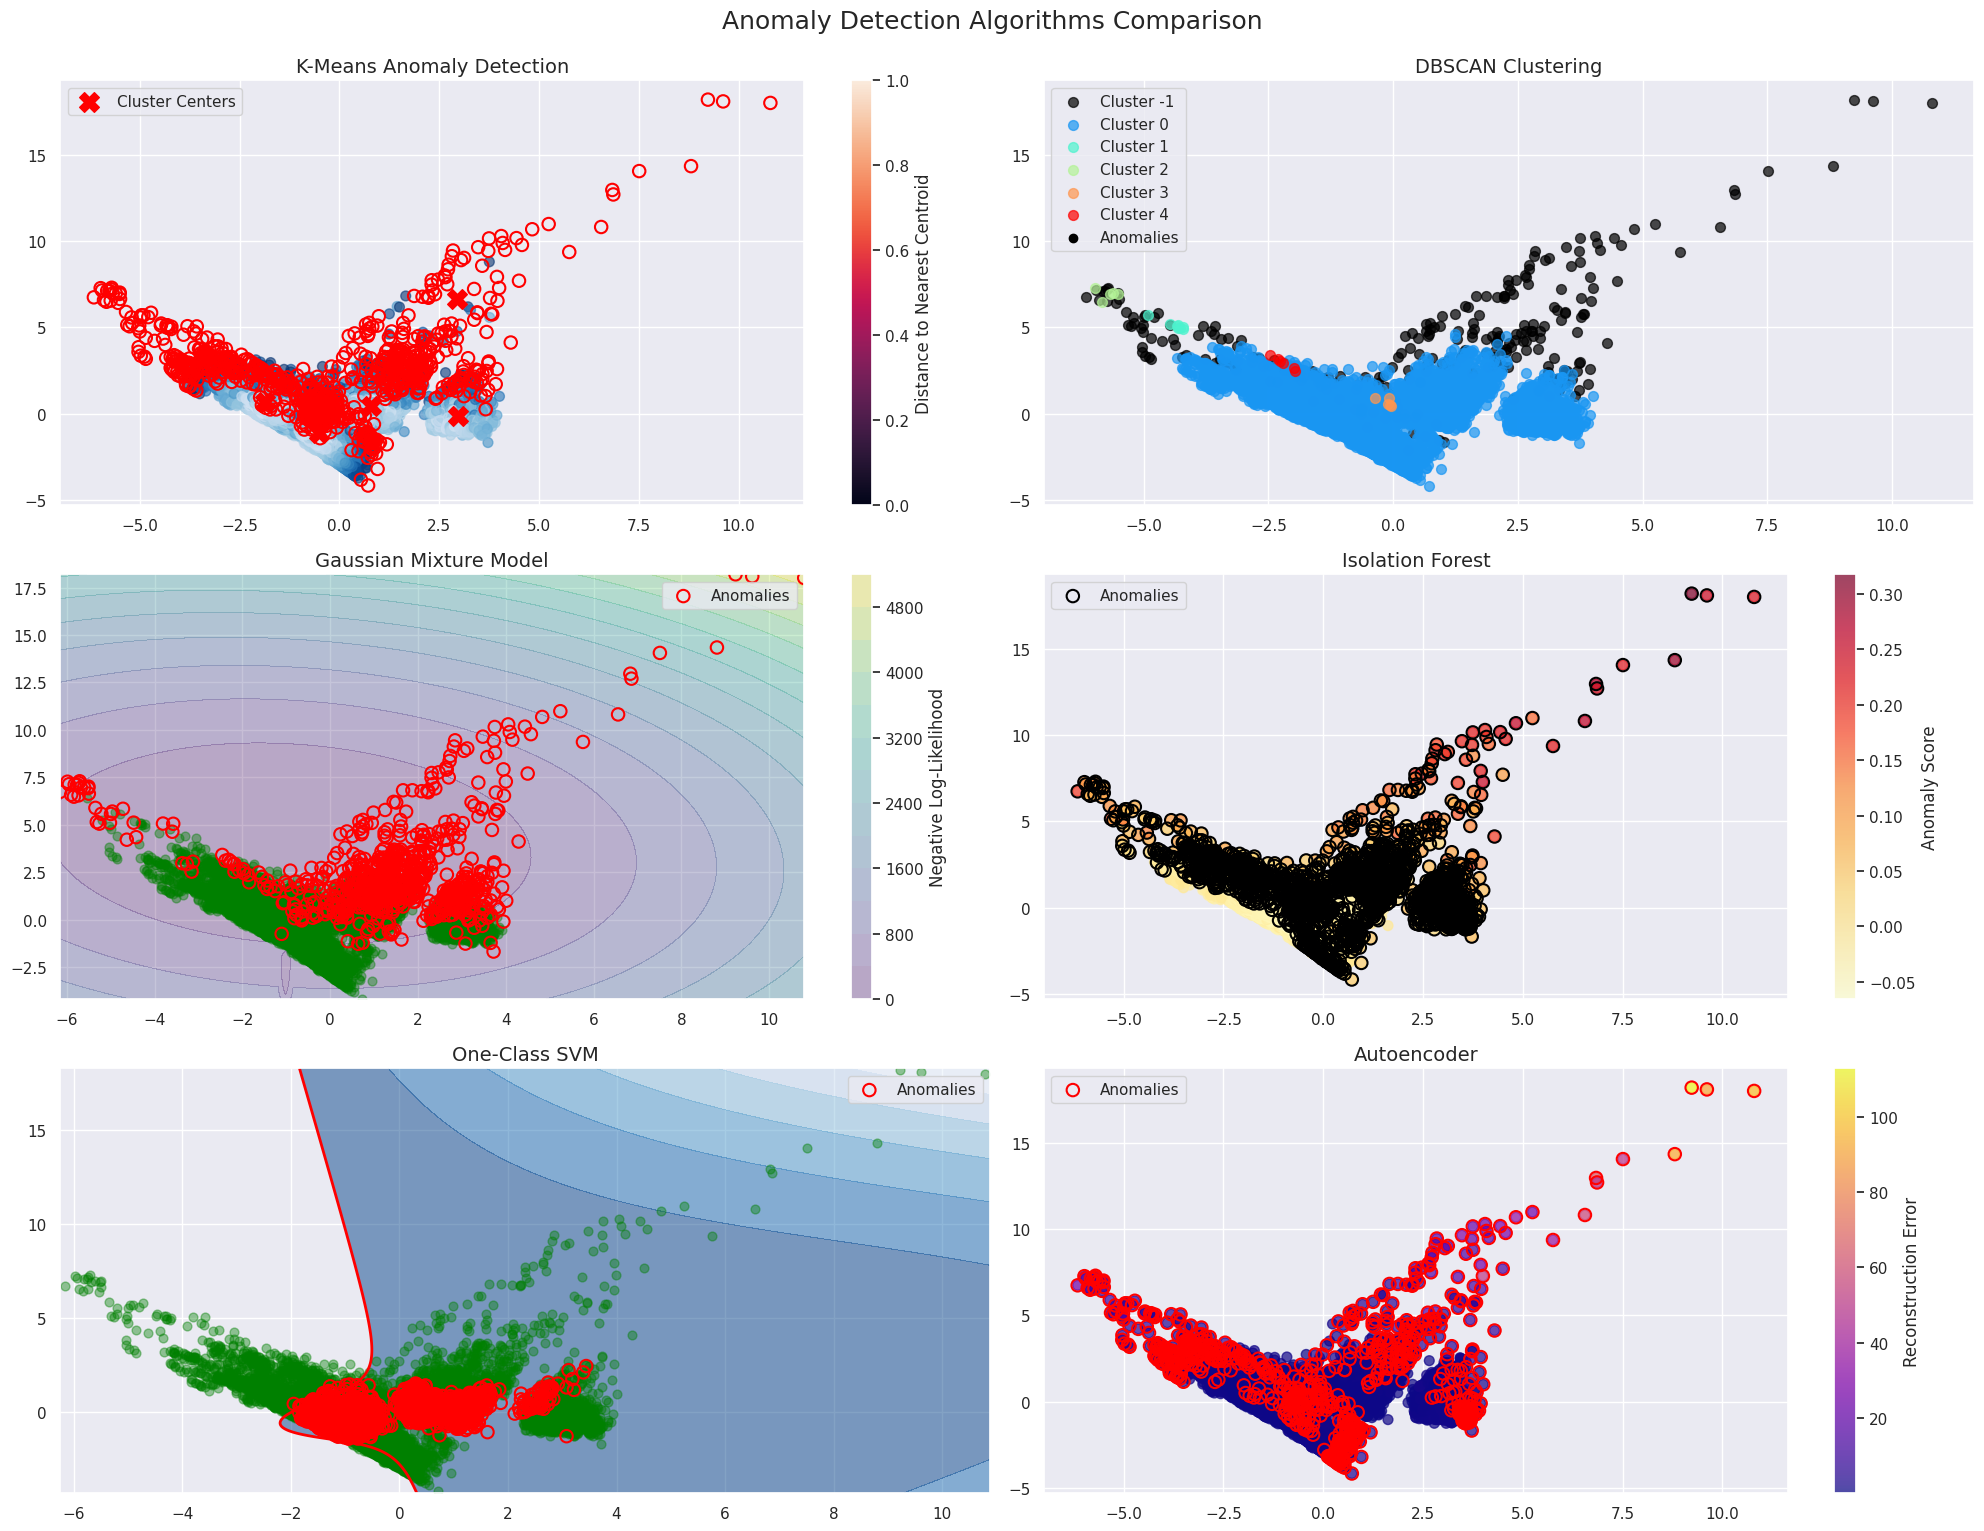

In [55]:
# %%

# Visualization setup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a figure with subplots for each algorithm
fig = plt.figure(figsize=(20, 15))

# 1. K-Means Visualization
plt.subplot(3, 2, 1)
# Plot normal points
plt.scatter(X_pca[~kmeans_anomalies, 0], X_pca[~kmeans_anomalies, 1],
            c=min_distances[~kmeans_anomalies], cmap='Blues', alpha=0.6, s=50)
# Highlight anomalies
plt.scatter(X_pca[kmeans_anomalies, 0], X_pca[kmeans_anomalies, 1],
            edgecolor='red', facecolors='none', s=80, linewidth=1.5)
# Plot cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.colorbar(label='Distance to Nearest Centroid')
plt.title('K-Means Anomaly Detection', fontsize=14)
plt.legend()

# 2. DBSCAN Visualization
plt.subplot(3, 2, 2)
# Plot clusters with different colors
unique_labels = np.unique(dbscan_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:  # Noise points (anomalies)
        col = 'black'
    mask = dbscan_labels == k
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[col], label=f'Cluster {k}', s=50, alpha=0.7)
plt.title('DBSCAN Clustering', fontsize=14)
# Create a custom legend for anomalies only
plt.scatter([], [], c='black', label='Anomalies')
plt.legend()

# 3. GMM Visualization
plt.subplot(3, 2, 3)
# Create a contour plot for the GMM components
if X_scaled.shape[1] > 1:
    x = np.linspace(X_pca[:, 0].min(), X_pca[:, 0].max(), 100)
    y = np.linspace(X_pca[:, 1].min(), X_pca[:, 1].max(), 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T

    # Transform back to original space
    XX_original = pca.inverse_transform(XX)
    Z = -gmm.score_samples(XX_original)
    Z = Z.reshape(X_grid.shape)

    # Plot the contours
    CS = plt.contourf(X_grid, Y_grid, Z, cmap='viridis', alpha=0.3, levels=15)
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('Negative Log-Likelihood')

# Plot regular points and anomalies
plt.scatter(X_pca[~gmm_anomalies, 0], X_pca[~gmm_anomalies, 1], c='green', alpha=0.4, s=40)
plt.scatter(X_pca[gmm_anomalies, 0], X_pca[gmm_anomalies, 1],
            edgecolor='red', facecolors='none', s=80, linewidth=1.5, label='Anomalies')
plt.title('Gaussian Mixture Model', fontsize=14)
plt.legend()

# 4. Isolation Forest Visualization
plt.subplot(3, 2, 4)
# Plot decision scores
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iso_scores, cmap='YlOrRd', s=50, alpha=0.7)
plt.colorbar(sc, label='Anomaly Score')
# Mark anomalies
plt.scatter(X_pca[iso_anomalies, 0], X_pca[iso_anomalies, 1],
            edgecolor='black', facecolors='none', s=80, linewidth=1.5, label='Anomalies')
plt.title('Isolation Forest', fontsize=14)
plt.legend()

# 5. One-Class SVM Visualization
plt.subplot(3, 2, 5)
# Create a mesh to plot decision boundary
h = 0.02  # Step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 0.1, X_pca[:, 0].max() + 0.1
y_min, y_max = X_pca[:, 1].min() - 0.1, X_pca[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Transform mesh points back to original space
Z_original = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
Z = oc_svm.decision_function(Z_original).reshape(xx.shape)

# Plot the decision boundary and points
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap='Blues', alpha=0.5)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.scatter(X_pca[~svm_anomalies, 0], X_pca[~svm_anomalies, 1], c='green', alpha=0.4, s=40)
plt.scatter(X_pca[svm_anomalies, 0], X_pca[svm_anomalies, 1],
            edgecolor='red', facecolors='none', s=80, linewidth=1.5, label='Anomalies')
plt.title('One-Class SVM', fontsize=14)
plt.legend()

# 6. Autoencoder Visualization
plt.subplot(3, 2, 6)
# Plot reconstruction error
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=mse, cmap='plasma', s=50, alpha=0.7)
plt.colorbar(sc, label='Reconstruction Error')
# Mark anomalies
plt.scatter(X_pca[autoencoder_anomalies, 0], X_pca[autoencoder_anomalies, 1],
            edgecolor='red', facecolors='none', s=80, linewidth=1.5, label='Anomalies')
plt.title('Autoencoder', fontsize=14)
plt.legend()

plt.tight_layout()
plt.suptitle('Anomaly Detection Algorithms Comparison', fontsize=18, y=1.02)
plt.show()

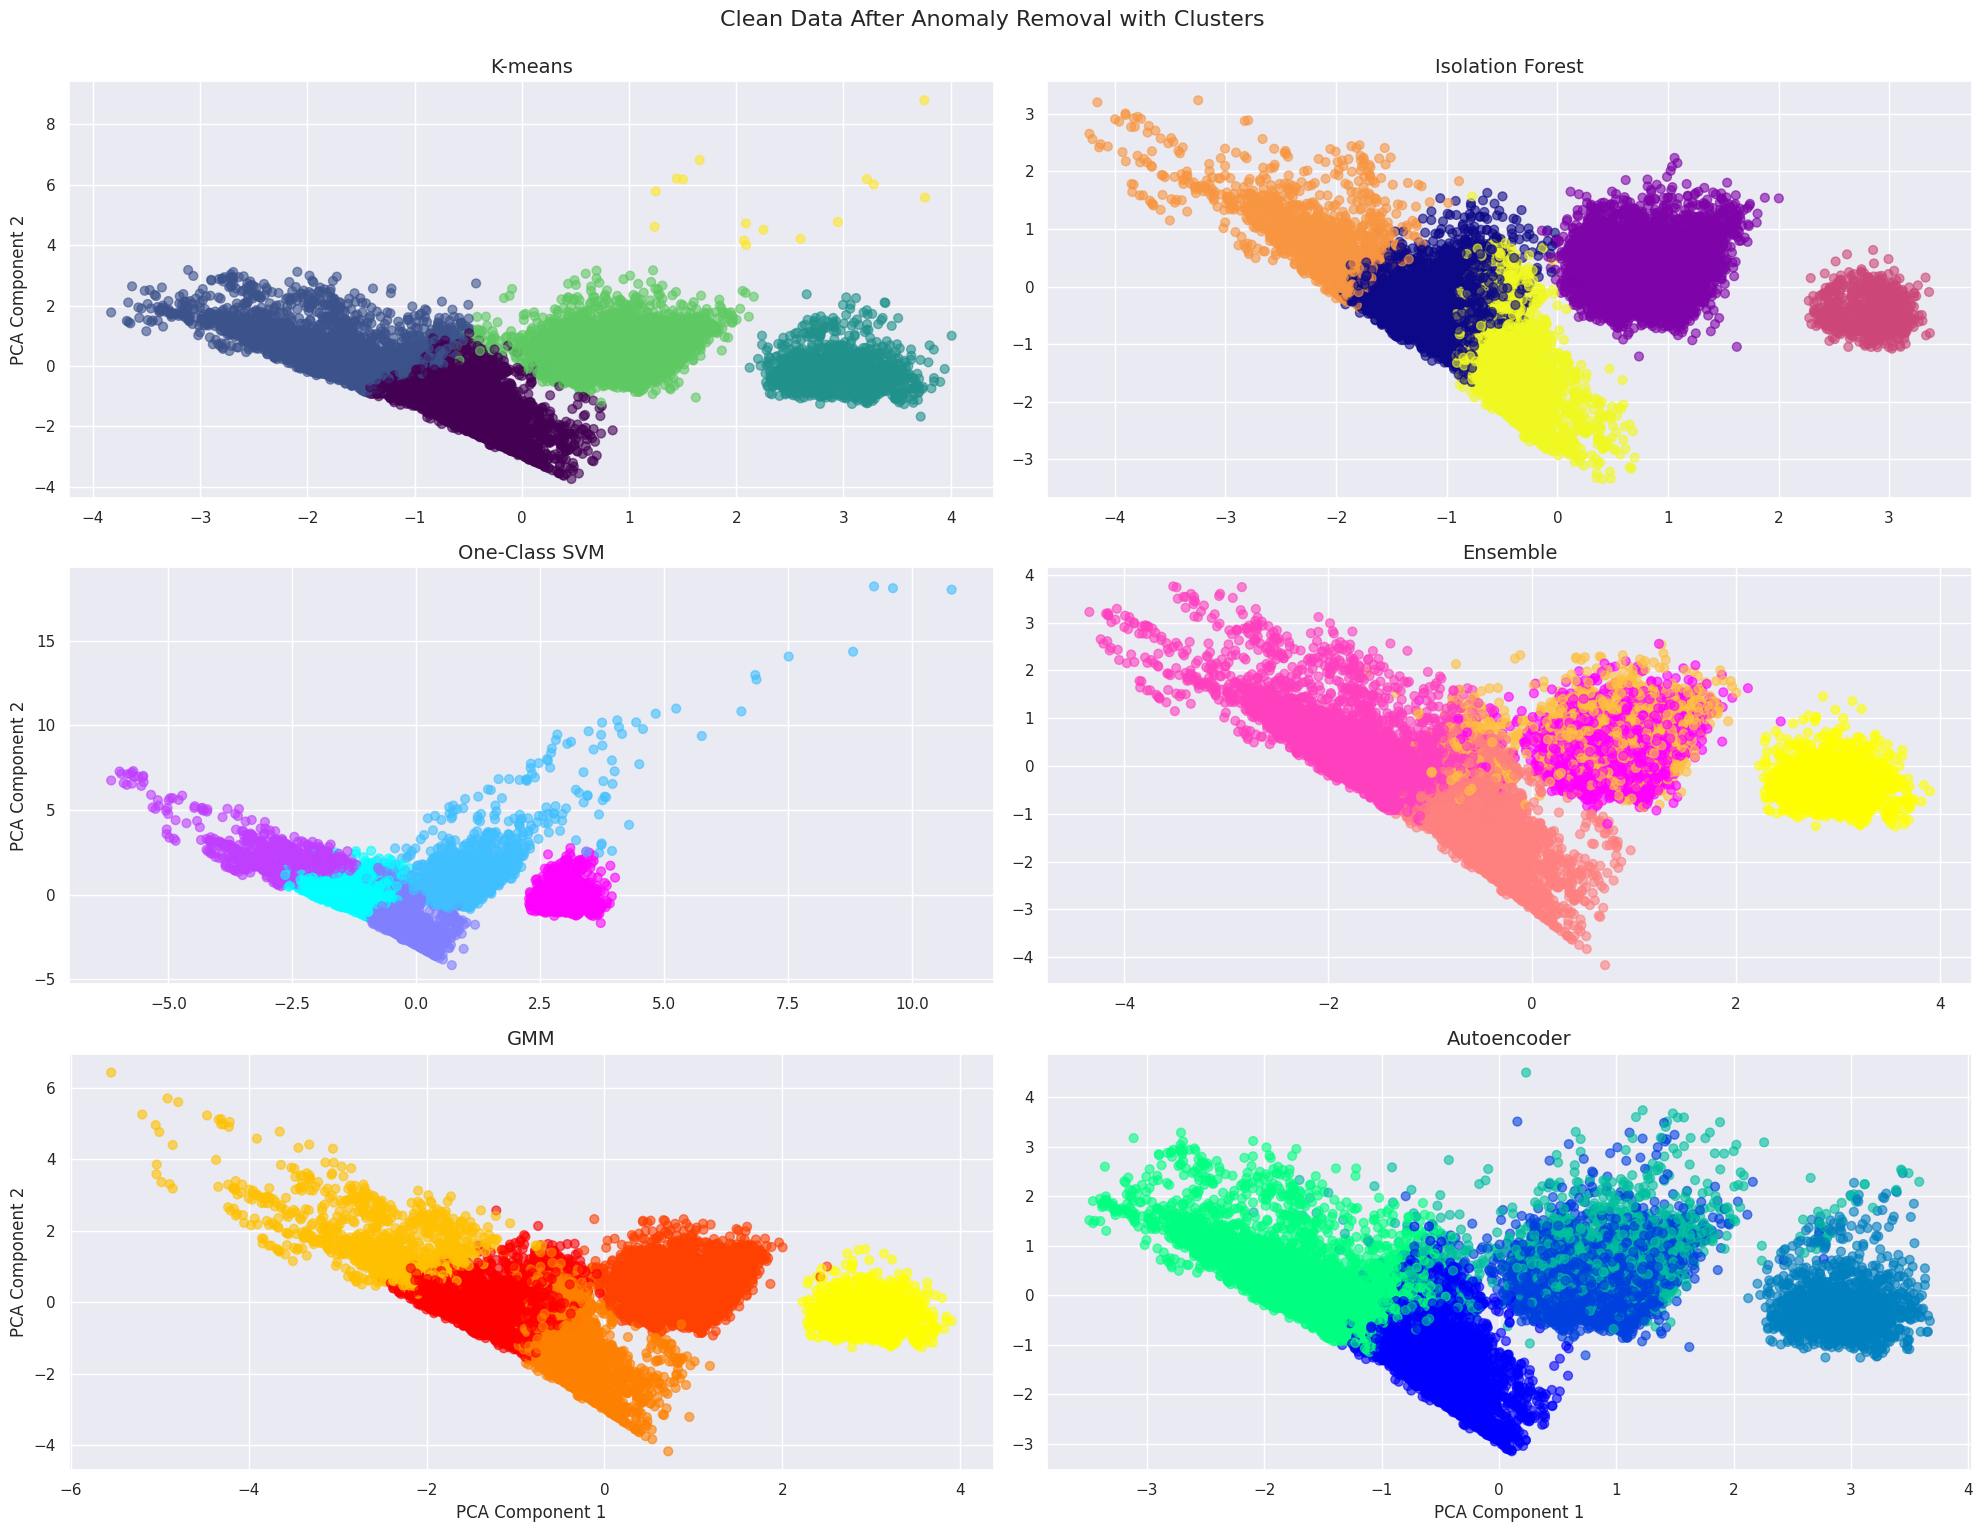

In [56]:
# %%

# Create figure for clean data visualization
plt.figure(figsize=(20, 15))  # Adjusted figure size for 6 subplots

# 1. Clean Data after K-means with clusters
plt.subplot(3, 2, 1)  # Adjusted subplot position
clean_kmeans = X_pca[~kmeans_anomalies]
kmeans_labels_clean = kmeans_labels[~kmeans_anomalies]
plt.scatter(clean_kmeans[:, 0], clean_kmeans[:, 1], c=kmeans_labels_clean, cmap='viridis', alpha=0.6, s=40)
plt.title('K-means', fontsize=14)
#plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# 2. Clean Data after Isolation Forest with clusters
plt.subplot(3, 2, 2)  # Adjusted subplot position
clean_iso = X_pca[~iso_anomalies]
# Apply KMeans clustering to the clean data
iso_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
iso_labels_clean = iso_kmeans.fit_predict(X_scaled[~iso_anomalies])
plt.scatter(clean_iso[:, 0], clean_iso[:, 1], c=iso_labels_clean, cmap='plasma', alpha=0.6, s=40)
plt.title('Isolation Forest', fontsize=14)
#plt.xlabel('PCA Component 1')
#plt.ylabel('PCA Component 2')

# 3. Clean Data after One-Class SVM with clusters
plt.subplot(3, 2, 3)  # Adjusted subplot position
clean_svm = X_pca[~svm_anomalies]
# Apply KMeans clustering to the clean data
svm_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
svm_labels_clean = svm_kmeans.fit_predict(X_scaled[~svm_anomalies])
plt.scatter(clean_svm[:, 0], clean_svm[:, 1], c=svm_labels_clean, cmap='cool', alpha=0.6, s=40)
plt.title('One-Class SVM', fontsize=14)
#plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# 4. Clean Data after Ensemble with clusters
plt.subplot(3, 2, 4)  # Adjusted subplot position
clean_ensemble = X_pca[~ensemble_anomalies]
clean_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
ensemble_labels_clean = clean_kmeans.fit_predict(X_scaled[~ensemble_anomalies])
plt.scatter(clean_ensemble[:, 0], clean_ensemble[:, 1], c=ensemble_labels_clean, cmap='spring', alpha=0.6, s=40)
plt.title('Ensemble', fontsize=14)
#plt.xlabel('PCA Component 1')
#plt.ylabel('PCA Component 2')

# 5. Clean Data after GMM with clusters
plt.subplot(3, 2, 5)  # New subplot for GMM
clean_gmm = X_pca[~gmm_anomalies]
# Apply KMeans clustering to the clean data
gmm_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
gmm_labels_clean = gmm_kmeans.fit_predict(X_scaled[~gmm_anomalies])
plt.scatter(clean_gmm[:, 0], clean_gmm[:, 1], c=gmm_labels_clean, cmap='autumn', alpha=0.6, s=40)
plt.title('GMM', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# 6. Clean Data after Autoencoder with clusters
plt.subplot(3, 2, 6)  # New subplot for Autoencoder
clean_autoencoder = X_pca[~autoencoder_anomalies]
# Apply KMeans clustering to the clean data
autoencoder_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
autoencoder_labels_clean = autoencoder_kmeans.fit_predict(X_scaled[~autoencoder_anomalies])
plt.scatter(clean_autoencoder[:, 0], clean_autoencoder[:, 1], c=autoencoder_labels_clean, cmap='winter', alpha=0.6, s=40)
plt.title('Autoencoder', fontsize=14)
plt.xlabel('PCA Component 1')
#plt.ylabel('PCA Component 2')


plt.tight_layout()
plt.suptitle('Clean Data After Anomaly Removal with Clusters', fontsize=16, y=1.02)
plt.show()

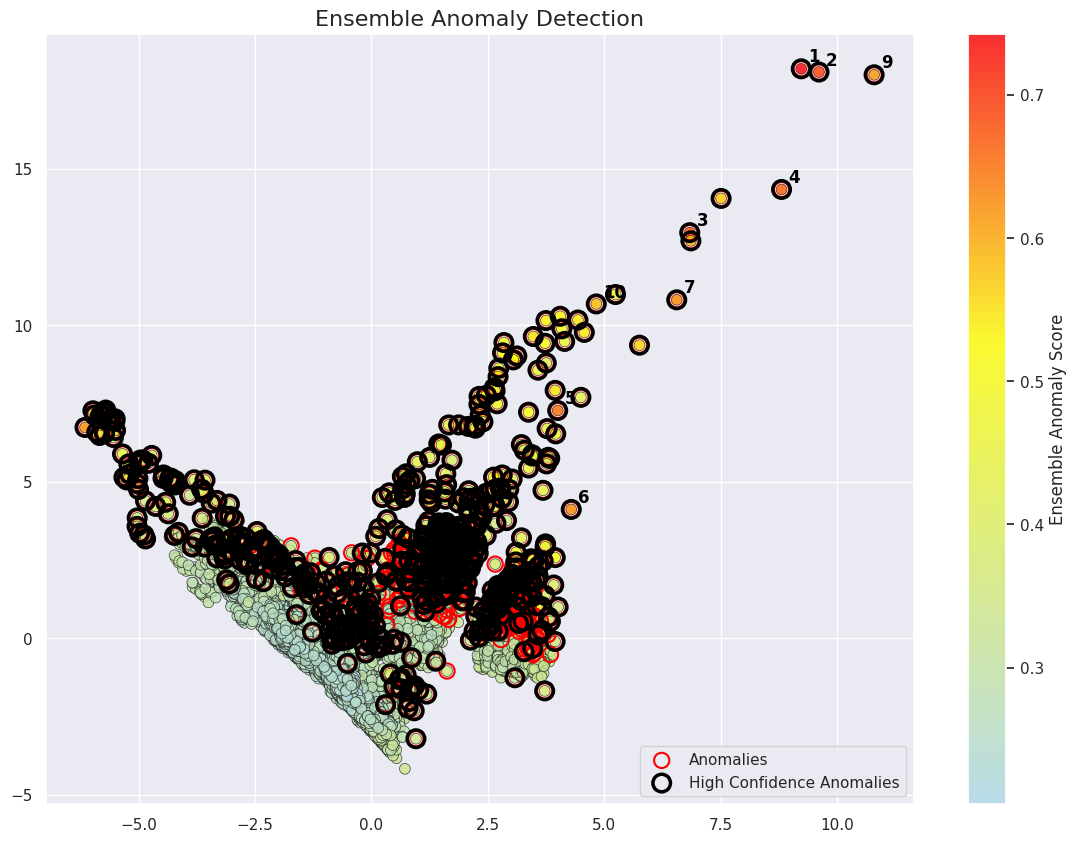

In [57]:
# %%

# Ensemble Method Visualization
plt.figure(figsize=(14, 10))

# Create a contour plot of ensemble scores
h = 0.02  # Step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 0.1, X_pca[:, 0].max() + 0.1
y_min, y_max = X_pca[:, 1].min() - 0.1, X_pca[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Create a custom colormap with gradient
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 'lightblue'), (0.6, 'yellow'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=100)

# Plot ensemble scores
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ensemble_anomaly_scores,
                cmap=custom_cmap, s=60, alpha=0.8, edgecolors='k', linewidth=0.5)
plt.colorbar(sc, label='Ensemble Anomaly Score')

# Mark anomalies with different confidence levels
plt.scatter(X_pca[ensemble_anomalies, 0], X_pca[ensemble_anomalies, 1],
            edgecolor='red', facecolors='none', s=120, linewidth=1.5, label='Anomalies')

# Mark high confidence anomalies
plt.scatter(X_pca[high_confidence_anomalies, 0], X_pca[high_confidence_anomalies, 1],
            edgecolor='black', facecolors='none', s=160, linewidth=2.5, label='High Confidence Anomalies')

# Plot top-10 anomalies with numbers
for i, idx in enumerate(top_anomaly_indices[:10]):
    plt.annotate(f"{i+1}", (X_pca[idx, 0], X_pca[idx, 1]),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=12, fontweight='bold', color='black')

plt.title('Ensemble Anomaly Detection', fontsize=16)
plt.legend(loc='lower right')
plt.show()

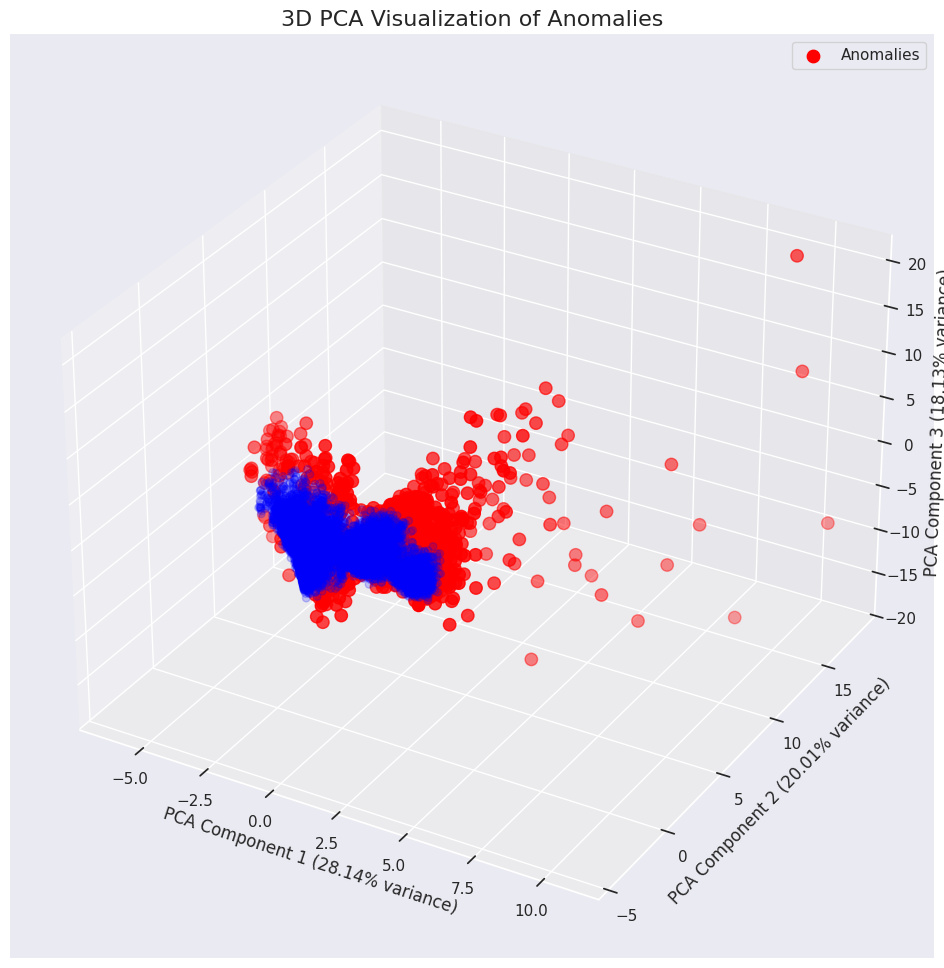

In [58]:
# %%

# 3D Visualization of top 3 PCA components with anomalies
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA for 3D visualization
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot normal points
ax.scatter(X_pca_3d[~ensemble_anomalies, 0],
           X_pca_3d[~ensemble_anomalies, 1],
           X_pca_3d[~ensemble_anomalies, 2],
           c='blue', alpha=0.2, s=30)

# Plot anomalies
ax.scatter(X_pca_3d[ensemble_anomalies, 0],
           X_pca_3d[ensemble_anomalies, 1],
           X_pca_3d[ensemble_anomalies, 2],
           c='red', s=80, label='Anomalies')

ax.set_xlabel(f'PCA Component 1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PCA Component 2 ({pca_3d.explained_variance_ratio_[1]:.2%} variance)')
ax.set_zlabel(f'PCA Component 3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
ax.set_title('3D PCA Visualization of Anomalies', fontsize=16)
plt.legend()
plt.show()

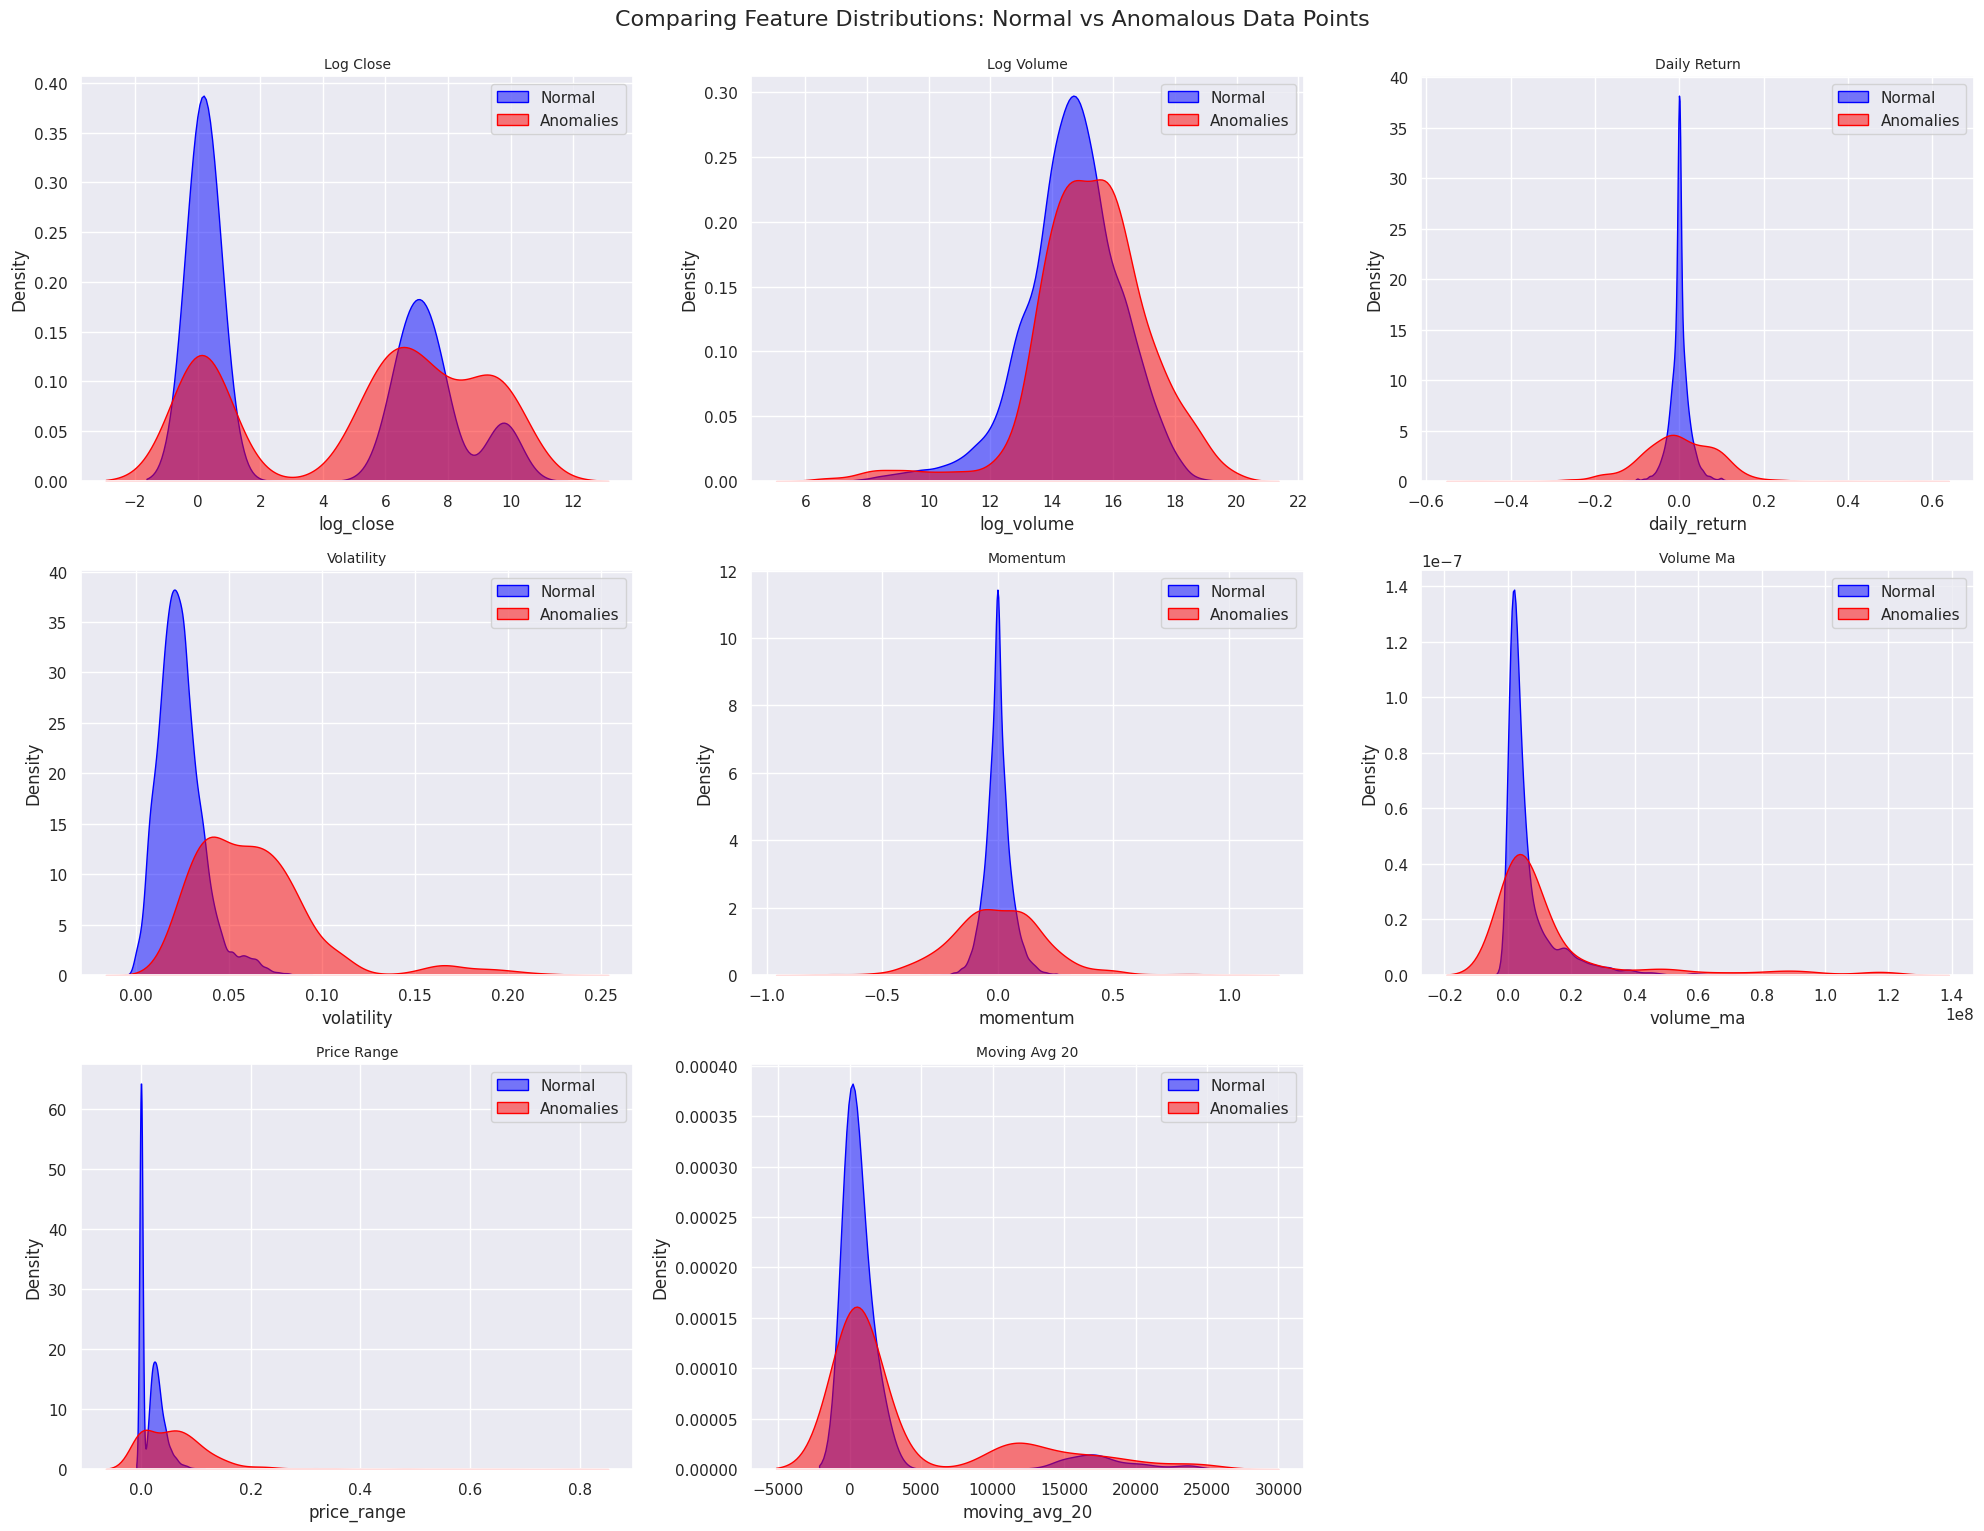

In [59]:
# %%

# Feature Distribution Comparison: Normal vs Anomalous
plt.figure(figsize=(20, 15))

# Plot feature distributions for normal vs anomalous points
for i, feature in enumerate(features_to_keep):
    plt.subplot(3, 3, i+1 if i < 8 else 9)

    # Get feature values for normal and anomalous points
    normal_vals = df[feature].iloc[~ensemble_anomalies]
    anomaly_vals = df[feature].iloc[ensemble_anomalies]

    # Plot distributions
    sns.kdeplot(normal_vals, fill=True, color='blue', alpha=0.5, label='Normal')
    sns.kdeplot(anomaly_vals, fill=True, color='red', alpha=0.5, label='Anomalies')

    # Make title more descriptive
    feature_name = feature.replace('_', ' ').title()
    plt.title(f'{feature_name}', fontsize=10)
    plt.legend()

plt.tight_layout()
plt.suptitle('Comparing Feature Distributions: Normal vs Anomalous Data Points', fontsize=16, y=1.02)
plt.show()

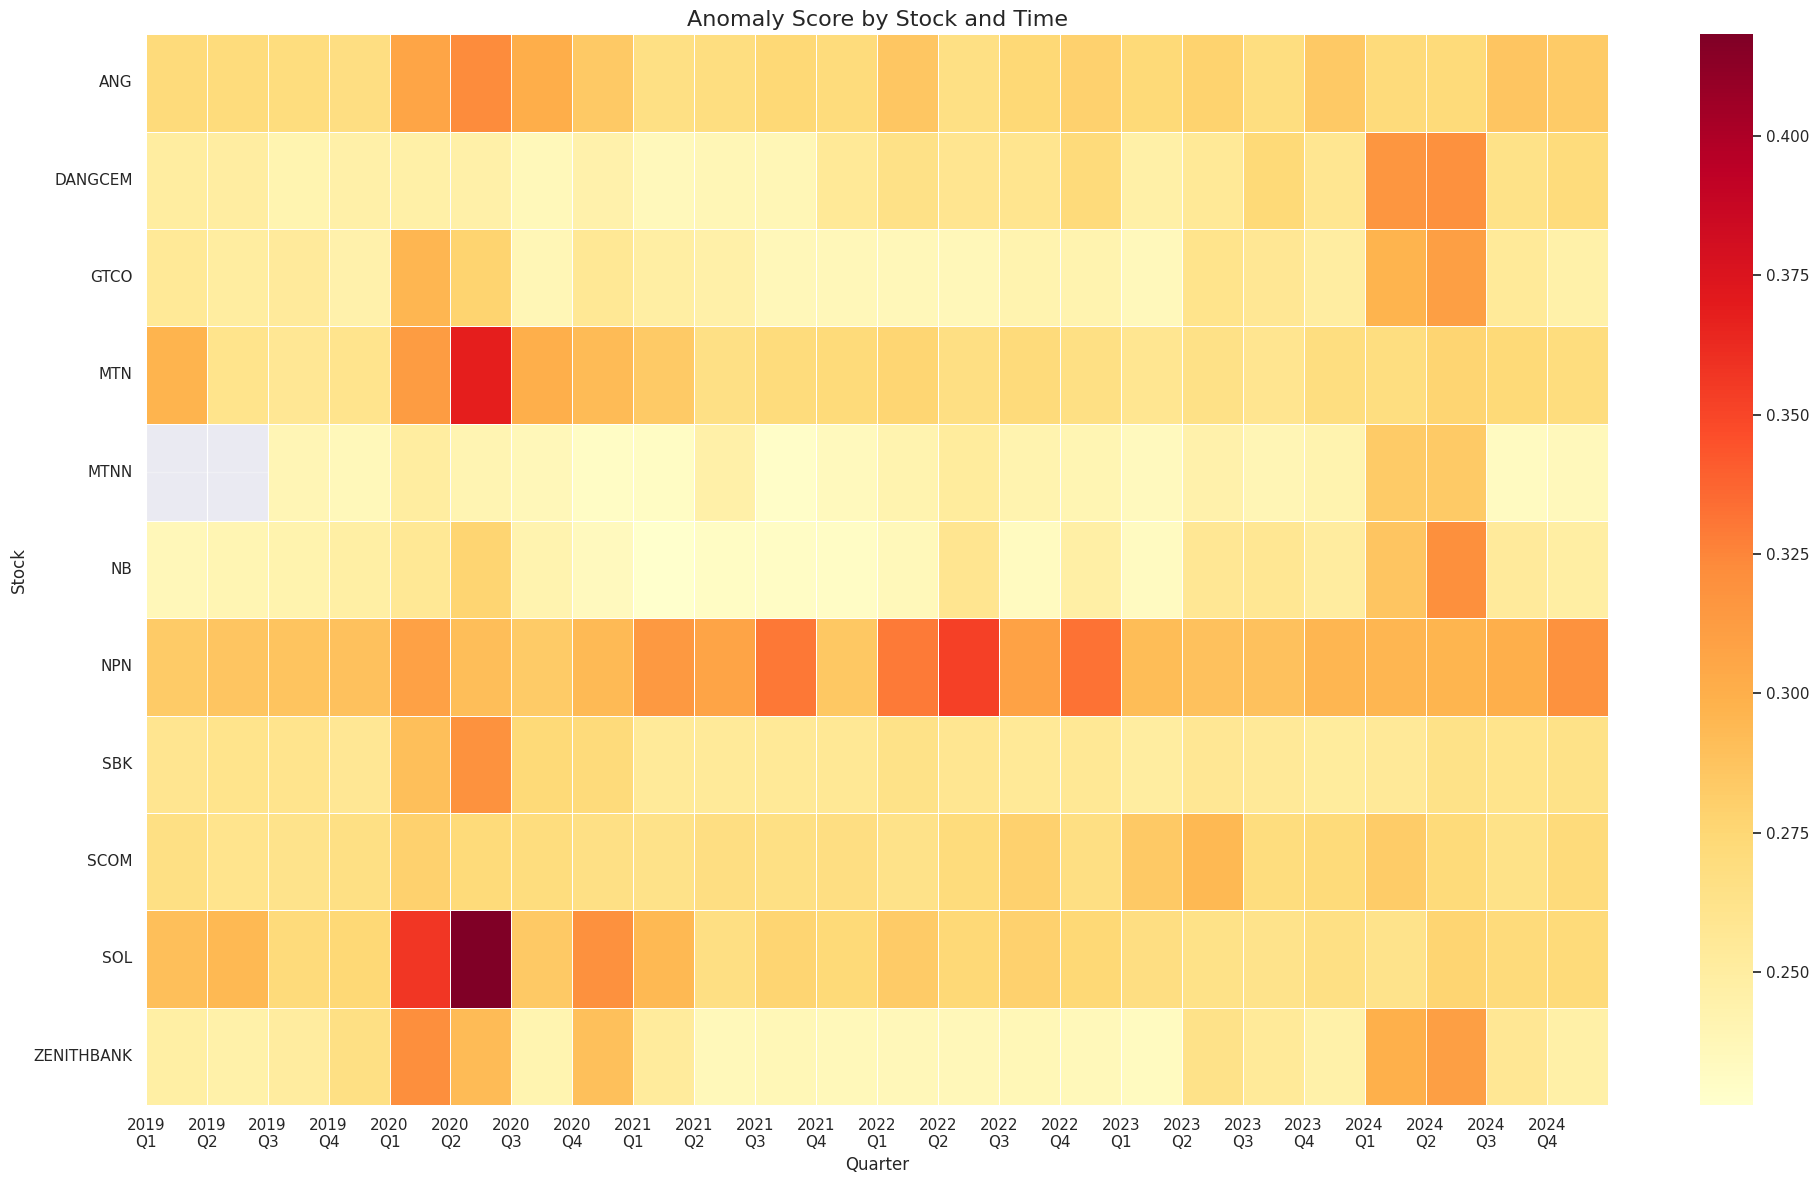

In [60]:
# %%

# Anomaly Heatmap by Stock and Time
if 'date' in df.columns and 'Name' in df.columns:
    # Create a pivot table of anomaly scores by stock and quarter
    df['anomaly_score'] = ensemble_anomaly_scores
    df['year_quarter'] = df['date'].dt.to_period('Q').astype(str)

    # Group by stock and quarter
    pivot = df.pivot_table(values='anomaly_score',
                           index='Name',
                           columns='year_quarter',
                           aggfunc='mean')

    # Plot heatmap
    plt.figure(figsize=(20, 12))
    sns.heatmap(pivot, cmap='YlOrRd', annot=False, linewidths=0.5)
    plt.title('Anomaly Score by Stock and Time', fontsize=16)
    plt.xlabel('Quarter')
    plt.ylabel('Stock')

    # Get quarter end dates for x-axis labels
    quarter_ends = pd.date_range(start=df['date'].min(),
                               end=df['date'].max(),
                               freq='Q')
    quarter_labels = [f"{d.year}\nQ{(d.month-1)//3 + 1}" for d in quarter_ends]

    # Set x-axis labels to quarter ends with better formatting
    plt.xticks(range(len(quarter_labels)), quarter_labels, rotation=0)
    plt.yticks(rotation=0, ha='right')

    # Add grid lines for better readability
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()